# Jobtech Interview Assignment

### Inspired by
### Job Skills extraction with LSTM and Word Embeddings - Nikita Sharma
### Implicit Skill Extraction Using Document Embeddings and Its Use in Job Recommendation - Akshay Gugnani,Hemant Misra
### https://kavita-ganesan.com/how-to-incorporate-phrases-into-word2vec-a-text-mining-approach/#.Y-MIo61ByUk

#### LSTM code from
#### https://towardsdatascience.com/long-short-term-memory-lstm-in-keras-2b5749e953ac
#### https://github.com/riteshranjan110/MediumBlogsCode/blob/master/LSTMblog1.ipynb

### Course https://www.udemy.com/course/nlp-natural-language-processing-with-python/

### Graphics
### https://www.analyticsvidhya.com/blog/2021/08/understanding-bar-plots-in-python-beginners-guide-to-data-visualization/
### https://problemsolvingwithpython.com/06-Plotting-with-Matplotlib/06.06-Bar-Charts-and-Pie-Charts/


### Other Sources
### https://www.nltk.org/book/ch03.html
### https://machinelearningknowledge.ai/complete-guide-to-spacy-tokenizer-with-examples/
### https://www.machinelearningplus.com/nlp/training-custom-ner-model-in-spacy/
### https://www.projectpro.io/recipes/use-word2vec
### https://radimrehurek.com/gensim/models/word2vec.html



# Import Modules

In [1]:
###Import modules
##Standard modules
import pandas as pd
import numpy as np
import re
import spacy

##Misc
from bs4 import BeautifulSoup
from collections import Counter
import csv
import os
import string
import spacy_download
from tqdm import tqdm
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#spacy_download.load_spacy("en_core_web_lg")

##Topic Modeling - LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#Word2vec
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import Phrases, KeyedVectors

#LSTM
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Bidirectional, Embedding ##CuDNNLSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Frequency Counter

In [2]:
## Frequency counter to analyse word counts 
def frequency_counter(column,top_num=25):
    return Counter(" ".join(column.str.lower()).split()).most_common(top_num)


# Cleaning job_title and company_name columns

In [3]:
##Functions to clean company_name and job_title columns

def remove_domain(text):
    text = text.lower()
    text = re.sub(r'\.com\s?', ' ',text) ##replace "".com" + up 1 white space after it with a single white space
    text = re.sub(r'\.co\s?', ' ',text)
    text = re.sub(r'\.sg\s?', ' ',text)
    text = re.sub(r'http\S+', ' ', text) ##replace http and any non-white space after it (stop when reach a whitespace)
    text = ' '.join(text.split())
    return text

#This standardize legal enitiy to --> "pte ltd", "llp", "inc", "ltd" format
def standardize_legal_entity(text):
    text = text.lower()
    text = re.sub(r'pte\.?', 'pte ', text) #replace "pte" and up to one "." with "pte "
    text = re.sub(r'ltd\.?', 'ltd', text)  
    text = re.sub(r'private\.?', 'pte ', text)
    text = re.sub(r'limited\.?', 'ltd', text)
    text = re.sub(r'llp\.?', 'llp ', text)
    text = re.sub(r'inc\.?,?', 'inc ',text)
    text = ' '.join(text.split())
    return text

#use to remove legal enitiy for text manipulation and search
def remove_legal_entity(text):
    text = text.lower()
    text = re.sub(r'pte\s', ' ', text)
    text = re.sub(r'ltd\s?', ' ', text)
    text = re.sub(r'inc\s', ' ',text)
    text = re.sub(r'llp\s?', ' ',text)
    text = ' '.join(text.split())
    return text

printable = set(string.printable) ##create set of printable object 
#use to remove all non-punctuation, non-digits, non-ascii_letters and non-whitespace.

def clean_job_title(text):
    text = text.lower()
    text = re.sub(r'#\w+\s?-?', ' ', text) #remove words after # (Usually #singaporeunited)
    text = re.sub(r'"[\s\S]+"\s?', ' ', text) #remove words in quotations as well as the quotation
    text = re.sub(r'\*+[\s\S]+\*+\s?', ' ', text) #remove words in *-type quatation
    text = re.sub(r'\A(-\s)?\s?(-\s)?\s?','',text) #remove - and white space at the start of the string
    text = re.sub(r'\?', ' ', text) #remove question mark
    text = ' '.join(text.split())
    if len(text) == 0:
        text = 'unknown'
    return text

## Turn 2849 Uniqes Job titles into 2390 unique job titles
def sanitize_job_title(text):
    text = ''.join(filter(lambda  x: x in printable, text))
    text = re.sub(r'(-\s){1}[\d\w\s\(\)\.&,\']+(\S+-\S+)?[\d\w\s\(\)\.&,\']+((ltd)|(llp)|(inc)|(limited)).*$',' ',text)
    ## Sometime there are company name in the job_title column. The formet is "- XXXXXXXX ltd"
    text = re.sub(r'\(.*?\)\s?-?',' ',text) #Remove text in ()
    text = re.sub(r'\[.*?\]',' ',text) #Remove text in []
    text = re.sub('urgent\s?-?', ' ', text)
    text = re.sub('[\*\!:;]+','',text) #remove symbol
    text = re.sub(r'\$[\d\.,]+\s?\|?k?\s?-?/?',' ',text) #Remove salary
    text = re.sub(r'x\s?\d+',' ',text) #Remove x number
    text = re.sub(r'\d+\s?x+',' ',text) #Remove number x
    text = re.sub(r'\d+\s?(day)s?\s?work?',' ',text) #Remove day work
    text = re.sub(r'\d\s((year)|(yr))\s(contract)?',' ',text) #Remove year contract
    text = re.sub(r'\d?\s?(to)?-?\s?\d{1,2}\s?((month)|(mth))s*\s(temp)?(contract)?',' ',text) #remve month contract
    text = re.sub(r'/hr,?', ' ', text) #Remove per hour
    text = re.sub(r'\d+\w?\w?\s?-\s?','', text) #Remove numbers coding
    text = re.sub(r'@.*','', text) #Remoce everything after at
    ###SPECIAL CASE
    text = re.sub(r'\d+\spax', ' ', text)
    text = re.sub(r'\d+\sinternship\s-', ' ', text)
    text = re.sub(r'\d+%', ' ', text)
    text = re.sub(r'\d{3,}',' ',text )
    ##Remove companies name and other information after job title
    text = re.sub(r'(\s-\s).*','',text)
    text = re.sub(r'-','',text)
    text = ' '.join(text.split())
    return text


# Replacing "confidenital" in company_name column

There are about total of 3000 postings.

1516 postings have "Confidential" under their company_name field. 

Some job postings have company name in its job_title column which can be use to augment company_name field.

Postings with company name in it job_title column have the following format in its name - XXX ltd or - XXX llp at or near the end of job_title string. 

We can use the following regular express to detect the company name ((-\s){1}[\d\w\s]+\s[(limited)(ltd)(llp)][\.\)]?)$ 

For postings that have company name in job_title but did not use - XXX ltd and - XXX llp format, it is still possilbe to extract some company name out.

We can create list of unique company name using data from company_name and job_title column.

In [4]:
##Functions to replace "confidential" in company_name comlumn with information from job_title column
##Also create unique company name pattern

##Out of 1517 posting with confidential company name, this function can replace the company name in 1020 postings. 
def replace_confidential(company_name,job_title):
    global i
    if company_name != 'confidential':
        modified_company_name = company_name
    else:
        search = re.search(r'(-\s){1}[\d\w\s\(\)\.&,\']+(\S+-\S+)?[\d\w\s\(\)\.&,\']+((ltd)|(llp)|(inc)|(limited)).*$',job_title)
        if search == None:
            modified_company_name = company_name
        else:
            text = search.group()
            text = re.sub(r'\A(-\s){1}','',text)
            modified_company_name = standardize_legal_entity(text)
            if modified_company_name not in ('confidential'):
                if modified_company_name.count("(") == modified_company_name.count(")"):
                    unique_company_name.add(modified_company_name)
    return modified_company_name

In [5]:
##Functions to create unqiue company name pattern
unique_company_name = set()
def extract_unique_company_name(company_name):
    if company_name not in ('confidential'):
         unique_company_name.add(company_name)

def create_company_name_pattern():
    global unique_company_name
    unique_company_name = list(unique_company_name)
    unique_company_name.sort(key=len,reverse=True)
    temp = []
    for name in unique_company_name:
        name = remove_legal_entity(name)
        if name not in ('confidential', '99', 99, 'works','enti'):
            temp.append(name)
    return '|'.join(name for name in temp)


Replace confidential is not 100% accurate.
for example if acutual company name is Micro Electronic in jobtitile, if there is company called Micro in the pattern but not Micro Electronic the search will capture the word Micro as company name.
If there is Micro Electronic in the company name, due to list sorting the pattern before hand, the function will capture Micro Elecrtronic

In [6]:
##Function to replace more confidential company name 
##Out of the remaining 497 posting with confidential company name, 
##this function can replace the company name in 109 postings. 

def replace_confidential_2(company_name,job_title):
    if company_name != 'confidential':
        modified_company_name = company_name
    else:
        search = re.search(company_name_pattern,job_title)
        if search == None:
            modified_company_name = company_name
        else:
            modified_company_name = company_name
            text = search.group()
            modified_company_name = remove_legal_entity(text)
    return modified_company_name

# Loading data and SPACY

In [7]:
## Read raw data file and NLP setup
df = pd.read_excel('test_data.xlsx')
nlp = spacy.load('en_core_web_lg')

In [8]:
df.head()

,job_id,job_title,job_description,date_posted,company_name
0,dc4c44bf442f4baa57f22233fee9195b75d62baa3b0265...,BUSINESS DEVELOPMENT (FREIGHT FORWARDING),- Roles &amp; Responsibilities : Job Role Desc...,2020-11-27,CALL LADE ENTERPRISES PTE LTD
1,39fc119781f2337a52de7300f21b76cda9b2c0202bfec9...,Secretary/PA,- Roles &amp; Responsibilities : Job Scope:<br...,2020-11-26,TALENT TRADER GROUP PTE. LTD.
2,2bdd91d7794575aaefee738ef6c831f7129fe6172f713c...,Temporary 3-6months Admin Assistant (Office ho...,Monday to Friday Office hoursLocation : Buona ...,2020-11-14,Confidential
3,0c170932727e0246f27feb1a5641d0e26f44d26d431be6...,Program Management,- Roles &amp; Responsibilities : Key Responsib...,2020-11-09,YASH TECHNOLOGIES SINGAPORE PTE. LIMITED
4,458658ef725f6384d4c056f6a8b01747331ba7c3c5c2e5...,Automotive Software Engineers (C Programming /...,&bull; MNC&bull; $3500 - $6000 Basic + AWS + V...,2020-11-15,Confidential


In [9]:
## Clean company_name
df['raw_company_name'] = df['company_name']
df['company_name'] = df['company_name'].map(remove_domain)
df['company_name'] = df['company_name'].map(standardize_legal_entity)

## Clean job_title column
df['raw_job_title'] = df['job_title']
df['job_title'] = df['job_title'].map(remove_domain)
df['job_title'] = df['job_title'].map(clean_job_title)

In [10]:
## Initiate Company Name Replacement Mechanism Part 1 -- Replacing 1020 out of 1517 confidential company names
df['company_name'].map(extract_unique_company_name)
df['company_name'] = df[['company_name','job_title']].apply(lambda x: replace_confidential(*x), axis =1)
## create company_name pattern
company_name_pattern = create_company_name_pattern()
## Initiate Company Name Replacement Mechanism Part 2
df['company_name'] = df[['company_name','job_title']].apply(lambda x: replace_confidential_2(*x), axis =1)

In [11]:
len(df[['job_title','company_name']][df['raw_company_name']=='Confidential'][df['company_name']!='confidential'])

C:\Users\Sarun\AppData\Local\Temp\ipykernel_81544\2780450824.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df[['job_title','company_name']][df['raw_company_name']=='Confidential'][df['company_name']!='confidential'])


1123

In [12]:
df[['job_title','company_name']][df['raw_company_name']=='Confidential'][df['company_name']!='confidential'][0:20]

C:\Users\Sarun\AppData\Local\Temp\ipykernel_81544\2416350677.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[['job_title','company_name']][df['raw_company_name']=='Confidential'][df['company_name']!='confidential'][0:20]


,job_title,company_name
2,temporary 3-6months admin assistant (office ho...,jobstudio pte ltd
4,automotive software engineers (c programming /...,ideals recruitment pte ltd
8,qa / qc manager (construction) (dredging) (2 y...,rs recruitment agency llp
13,1 year contract general ledger executive assis...,recruit express pte ltd
17,"senior executive / executive, finance - capita...",capita
18,engineering assistant (calibration team) - cap...,capita pte ltd
20,onboarding specialist - recruitfirst pte. ltd,recruitfirst pte ltd
22,software engineer - weconex holdings (sea) pte...,weconex holdings (sea) pte ltd
27,medical affairs manager [nephrology] - integri...,integrity partners pte ltd
29,sales and marketing executive - recruit expres...,recruit express pte ltd


In [13]:
df[['job_title','company_name','raw_company_name']].to_csv('exel_01_replace_company_name.csv')

In [14]:
##Sanatized job_title column
df['job_title'] = df['job_title'].map(sanitize_job_title)
df['job_title'].to_csv('test.csv')

In [15]:
df[['job_title','company_name']][0:30]

,job_title,company_name
0,business development,call lade enterprises pte ltd
1,secretary/pa,talent trader group pte ltd
2,temporary admin assistant,jobstudio pte ltd
3,program management,yash technologies singapore pte ltd
4,automotive software engineers,ideals recruitment pte ltd
5,managing consultant,michael page international pte ltd
6,lab technician,recruitexpress
7,senior software engineer,openbet singapore pte ltd
8,qa / qc manager,rs recruitment agency llp
9,"executive/senior executive, graduate studies",national university of singapore


In [16]:
df[['raw_job_title','job_title']][0:30]

,raw_job_title,job_title
0,BUSINESS DEVELOPMENT (FREIGHT FORWARDING),business development
1,Secretary/PA,secretary/pa
2,Temporary 3-6months Admin Assistant (Office ho...,temporary admin assistant
3,Program Management,program management
4,Automotive Software Engineers (C Programming /...,automotive software engineers
5,Managing Consultant,managing consultant
6,Lab Technician - $1700 #ERH,lab technician
7,Senior Software Engineer,senior software engineer
8,QA / QC MANAGER (Construction) (Dredging) (2 y...,qa / qc manager
9,"Executive/Senior Executive, Graduate Studies (...","executive/senior executive, graduate studies"


In [17]:
df[['raw_company_name','company_name']][0:30]

,raw_company_name,company_name
0,CALL LADE ENTERPRISES PTE LTD,call lade enterprises pte ltd
1,TALENT TRADER GROUP PTE. LTD.,talent trader group pte ltd
2,Confidential,jobstudio pte ltd
3,YASH TECHNOLOGIES SINGAPORE PTE. LIMITED,yash technologies singapore pte ltd
4,Confidential,ideals recruitment pte ltd
5,MICHAEL PAGE INTERNATIONAL PTE LTD,michael page international pte ltd
6,RecruitExpress,recruitexpress
7,OPENBET SINGAPORE PTE. LIMITED,openbet singapore pte ltd
8,Confidential,rs recruitment agency llp
9,NATIONAL UNIVERSITY OF SINGAPORE,national university of singapore


### Categorized job by category

In [18]:
## Semi-manually group each posting to different type of job category using basic search function in job_title column
job_pattern = []
def basic_job_pattern_creator(jobs_title):
    return job_pattern.append('|'.join(name for name in jobs_title))

## FILTER OUT THOSE WITH LOWER THAN 90 count
basic_job_pattern_creator(['technician','electrician'])
basic_job_pattern_creator(['hr','human'])
basic_job_pattern_creator(['account'])
basic_job_pattern_creator(['finance','financial','bank'])
basic_job_pattern_creator(['admin'])
basic_job_pattern_creator(['chef','cook','kitchen','barista','bartender','restaurant'])
basic_job_pattern_creator(['healthcare','medical','nurse','hospital','pharma','clinic','patient'])
basic_job_pattern_creator(['analytic','analyst','data'])
basic_job_pattern_creator(['marketing','market','sales'])
basic_job_pattern_creator(['customer','service','call'])
basic_job_pattern_creator(['software','developer','java','network','system'])
basic_job_pattern_creator(['engineer'])
basic_job_pattern_creator(['manager'])
# basic_job_pattern_creator(['teacher','school','principal'])
##TOO LOW NUMBER --> less than 2%
## basic_job_pattern_creator(['business'])
## basic_job_pattern_creator(['operations'])
## basic_job_pattern_creator(['consultant'])
## basic_job_pattern_creator(['driver'])
## basic_job_pattern_creator(['designer','graphic'])
## basic_job_pattern_creator(['project'])
## basic_job_pattern_creator(['research'])


def create_job_category(job_title):
    i = 0
    for category in job_pattern:
        i += 1
        if re.search(category, job_title):
            job_category = category
            break
        else:
            job_category = 'other'
    return job_category


In [19]:
df['job_category'] = df["job_title"].map(create_job_category)

## list of all job_category for late use
job_category_in_df = []
for category in df['job_category']:
    job_category_in_df.append(category)
job_category_in_df = list(set(job_category_in_df))

In [20]:

df[['job_title','job_category']][0:30]

,job_title,job_category
0,business development,other
1,secretary/pa,other
2,temporary admin assistant,admin
3,program management,other
4,automotive software engineers,software|developer|java|network|system
5,managing consultant,other
6,lab technician,technician|electrician
7,senior software engineer,software|developer|java|network|system
8,qa / qc manager,manager
9,"executive/senior executive, graduate studies",other


In [21]:
frequency_counter(df['job_category'],25)

[('other', 1125),
 ('manager', 260),
 ('engineer', 246),
 ('marketing|market|sales', 199),
 ('software|developer|java|network|system', 183),
 ('analytic|analyst|data', 144),
 ('admin', 126),
 ('account', 124),
 ('healthcare|medical|nurse|hospital|pharma|clinic|patient', 122),
 ('customer|service|call', 119),
 ('finance|financial|bank', 99),
 ('hr|human', 89),
 ('technician|electrician', 88),
 ('chef|cook|kitchen|barista|bartender|restaurant', 76)]

Text(0, 0.5, 'Job Category')

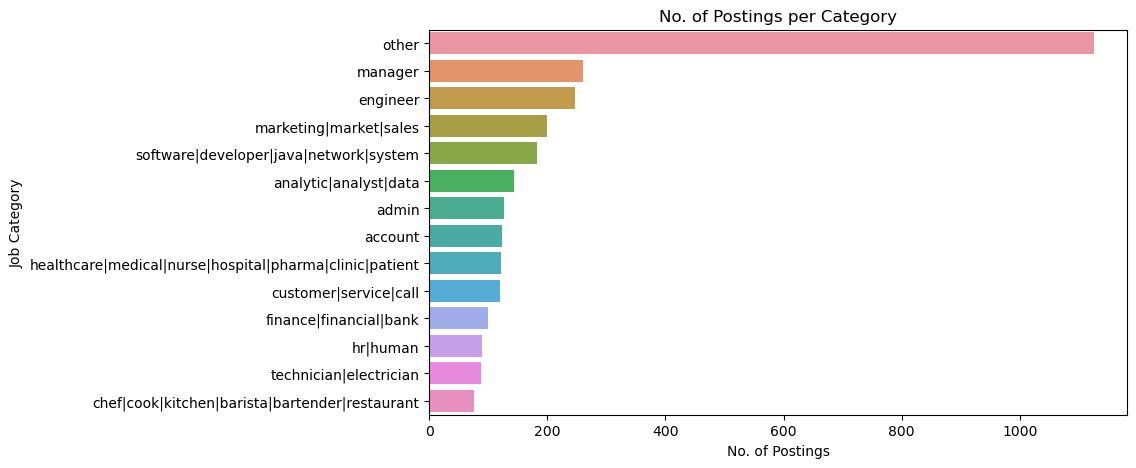

In [22]:
job_category = df['job_category'].value_counts().index
plt.figure(figsize=(9, 5))
sns.countplot(data=df, y='job_category', order=job_category)
plt.title('No. of Postings per Category')
plt.xlabel('No. of Postings')
plt.ylabel('Job Category')

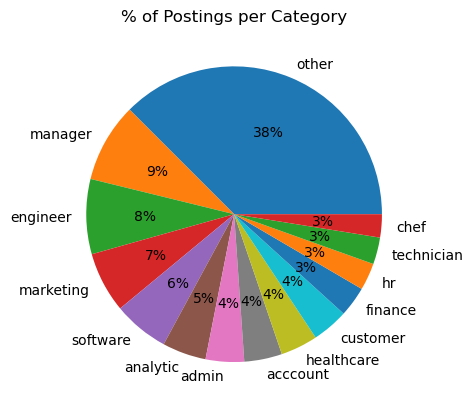

In [23]:
data = [1125,260,246,199,183,144,126,124,122,119,99,89,88,76]
keys = ['other','manager','engineer','marketing','software','analytic','admin','acccount','healthcare','customer','finance','hr','technician','chef']

# plotting data on chart
plt.pie(data, labels=keys, autopct='%.0f%%')
plt.title('% of Postings per Category')

# display
plt.show()

# Cleaning job_description

In [24]:
def html_parser(text):
    text = re.sub(r'<br/>', ' ', text)
    text = re.sub(r'</br>', ' ',text)
    text = BeautifulSoup(text, 'lxml')
    text = text.get_text()
    text = ''.join(filter(lambda x: x in printable, text)) #Remove non-printable
    text = re.sub('\A\s?-\s?', '', text) #Remove - in front of the string
    text = " ".join(text.split())
    return text

df['job_description'] = df['job_description'].map(html_parser)
df['raw_job_description'] = df['job_description']

C:\Users\Sarun\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [25]:
df['job_description'][0:10]

0    Roles & Responsibilities : Job Role Descriptio...
1    Roles & Responsibilities : Job Scope: Full spe...
2    Monday to Friday Office hoursLocation : Buona ...
3    Roles & Responsibilities : Key Responsibilitie...
4    MNC $3500 - $6000 Basic + AWS + Variable Bonus...
5    Roles & Responsibilities : PRIMARY OBJECTIVE T...
6    Local Food Manufacturing company is hiring for...
7    Roles & Responsibilities : OpenBet (now SG Dig...
8    MNC 2 years contract Good benefits 5 days work...
9    Roles & Responsibilities : To assist in the ad...
Name: job_description, dtype: object

In [26]:
df[['job_id','job_title','job_description','date_posted','company_name','job_category']].to_csv('exel_02_clean_job_posting.csv')

Get list of sentence that appear too many times in the corpus, most common 180 sentences repated at least 4 times + has no skills words.
Will remove the sentence with legth greater than 3.

In [27]:
sentence_in_corpus = []
too_frequent_sentences = []
for job_description in df['job_description']:
    for sentence in sent_tokenize(job_description):
        sentence_in_corpus.append(sentence)

frequency_sentence_in_corpus = Counter(sentence_in_corpus)
for sentence in frequency_sentence_in_corpus.most_common(180):
    if len(sentence[0]) > 3:
        too_frequent_sentences.append(sentence[0])

def remove_repeat_sentence(job_description):
    temp = []
    for sentence in sent_tokenize(job_description):
        if 'skill' in sentence:
            temp.append(sentence)
        elif sentence not in too_frequent_sentences:
            temp.append(sentence)
    return ' '.join(temp)

In [28]:
frequency_sentence_in_corpus.most_common(20)

[('Recruiters, please dont contact this job advertiser.no -- Please, no phone calls about this job!no -- Reposting this message elsewhere is NOT OK.',
  116),
 ('No.', 84),
 ('We regret that only shortlisted candidates will be notified.', 78),
 ('2.', 42),
 ('3.', 40),
 ('> no -- Principals only.', 34),
 ('All applications will be treated with the strictest confidence.', 33),
 ('4.', 31),
 (': 08C2893', 29),
 ('If you wish to withdraw your consent, please drop us an email at [emailprotected] to let us know.',
  28),
 ('**We regret to inform that only shortlisted candidates would be notified.',
  27),
 ('We regret that only short-listed applicants will be notified.', 24),
 ('5.', 23),
 ('Please access our website at www.capitasingapore.com for a copy of our Privacy Policy.',
  23),
 ('99C4599', 21),
 ('For more job opportunities, please visit our website at www.recruit-expert.com EA Licence: 19C9701 Registration: R1328870',
  20),
 ('We regret to inform that only shortlisted candidates 

In [29]:
df['job_description'] = df['job_description'].map(remove_repeat_sentence)

In [30]:
sentence_in_corpus = []
too_frequent_sentences = []
for job_description in df['job_description']:
    for sentence in sent_tokenize(job_description):
        sentence_in_corpus.append(sentence)

frequency_sentence_in_corpus = Counter(sentence_in_corpus)
for sentence in frequency_sentence_in_corpus.most_common(177):
    if len(sentence[0]) > 3:
        too_frequent_sentences.append(sentence[0])

frequency_sentence_in_corpus.most_common(20)

[('No.', 84),
 ('2.', 42),
 ('3.', 40),
 ('4.', 31),
 ('5.', 23),
 ('1.', 13),
 ('6.', 13),
 ('7.', 10),
 ('??', 9),
 ('!', 7),
 ('**', 6),
 ('no.', 6),
 ('8.', 6),
 ('Excellent written and verbal communication skills.', 5),
 ('Excellent communication skills.', 4),
 ('Strong communication skills.', 4),
 ('Perform critical inventory tasks to ensure the correct quantity of items are in stock.',
  4),
 ('Maintain updated and accurate records of inventory, including transfers and cycle counts.',
  4),
 ('Review documentation and monitor product codes to search for discrepancies; troubleshoot quantity discrepancies between stock and records.',
  4),
 ('Develop and implement improvement to existing operational procedures in order to maximize efficiency and cut operations costs.',
  4)]

In [31]:
df[['job_id','raw_job_title','job_title','job_description','date_posted','company_name','job_category']].to_csv('exel_03_clean_job_posting_v2.csv')

The data is now clean and standardized. Frequently appeared sentences have been removed. Those are mainly posted by job agents or non-skill related so their removal would not have negative impact on the analysis.

Further data manipulation such as rempocal of stopwords, lemmatization, and tokenization will be done on case-by-case basis depending on the type of analysis we want. 

In [32]:
## Functions for POS tagging

def pos_header():
    print(f"{'text':{20}} {'POS':{6}} {'TAG':{6}} {'Dep':{6}} {'POS explained':{20}} {'tag explained'}")
    
def extract_pos(text):
    doc = nlp(text)
    for token in doc:
        print(f'{token.text:{20}} {token.pos_:{6}} {token.tag_:{6}} {token.dep_:{6}} {spacy.explain(token.pos_):{20}} {spacy.explain(token.tag_)}')

In [33]:
pos_header()
df['job_description'][0:2].map(extract_pos)

text                 POS    TAG    Dep    POS explained        tag explained
Roles                PROPN  NNPS   nsubj  proper noun          noun, proper plural
&                    CCONJ  CC     cc     coordinating conjunction conjunction, coordinating
Responsibilities     PROPN  NNPS   conj   proper noun          noun, proper plural
:                    PUNCT  :      punct  punctuation          punctuation mark, colon or ellipsis
Job                  NOUN   NN     compound noun                 noun, singular or mass
Role                 NOUN   NN     compound noun                 noun, singular or mass
Description          NOUN   NN     appos  noun                 noun, singular or mass
:                    PUNCT  :      punct  punctuation          punctuation mark, colon or ellipsis
Responsible          ADJ    JJ     amod   adjective            adjective (English), other noun-modifier (Chinese)
for                  ADP    IN     prep   adposition           conjunction, subordinating 

0    None
1    None
Name: job_description, dtype: object

In [34]:
pos_list = []
for sentence in df['job_description']:
    sentence = nlp(sentence)
    for token in sentence:
        if token.pos_ == 'NOUN':
            pos_list.append(token.text)

Counter(pos_list).most_common(25)

[('experience', 3548),
 ('team', 2515),
 ('skills', 2440),
 ('management', 2107),
 ('business', 2033),
 ('years', 1644),
 ('work', 1610),
 ('data', 1549),
 ('development', 1345),
 ('communication', 1279),
 ('project', 1236),
 ('customer', 1201),
 ('knowledge', 1137),
 ('customers', 1053),
 ('Responsibilities', 1045),
 ('support', 1042),
 ('service', 1040),
 ('candidates', 1037),
 ('Experience', 1023),
 ('environment', 1014),
 ('requirements', 1009),
 ('resume', 998),
 ('sales', 965),
 ('projects', 936),
 ('process', 907)]

In [35]:
pos_list = []
for sentence in df['job_description']:
    sentence = nlp(sentence)
    for token in sentence:
        if token.pos_ == 'PROPN':
            pos_list.append(token.text)

Counter(pos_list).most_common(25)

[('Job', 1234),
 ('Responsibilities', 1152),
 ('Singapore', 1071),
 ('Roles', 940),
 ('Diploma', 809),
 ('Management', 801),
 ('Requirements', 786),
 ('Degree', 665),
 ('Engineering', 619),
 ('Pte', 566),
 ('Business', 556),
 ('MS', 528),
 ('Manager', 523),
 ('EA', 521),
 ('Office', 520),
 ('IT', 495),
 ('Ltd', 456),
 ('Microsoft', 419),
 ('Min', 384),
 ('Data', 368),
 ('Science', 366),
 ('Word', 363),
 ('Team', 351),
 ('Computer', 350),
 ('Services', 348)]

In [36]:
pos_list = []
for sentence in df['job_description']:
    sentence = nlp(sentence)
    for token in sentence:
        if token.pos_ == 'ADJ':
            pos_list.append(token.text)

Counter(pos_list).most_common(25)

[('other', 1512),
 ('new', 1246),
 ('relevant', 1117),
 ('technical', 965),
 ('Able', 958),
 ('Good', 954),
 ('such', 842),
 ('good', 809),
 ('-', 755),
 ('Strong', 733),
 ('internal', 677),
 ('strong', 675),
 ('able', 655),
 ('least', 633),
 ('financial', 572),
 ('equivalent', 539),
 ('high', 530),
 ('interpersonal', 528),
 ('Interested', 526),
 ('various', 521),
 ('related', 519),
 ('Responsible', 500),
 ('key', 485),
 ('external', 470),
 ('Excellent', 455)]

In [37]:
pos_list = []
for sentence in df['job_description']:
    sentence = nlp(sentence)
    for token in sentence:
        if token.pos_ == 'VERB':
            pos_list.append(token.text)

Counter(pos_list).most_common(25)

[('work', 1632),
 ('ensure', 1339),
 ('including', 1119),
 ('required', 1045),
 ('working', 1022),
 ('related', 808),
 ('have', 776),
 ('Ensure', 768),
 ('assigned', 766),
 ('Provide', 704),
 ('provide', 678),
 ('apply', 635),
 ('develop', 630),
 ('manage', 618),
 ('Assist', 608),
 ('Perform', 575),
 ('based', 523),
 ('support', 521),
 ('looking', 500),
 ('using', 493),
 ('maintain', 472),
 ('shortlisted', 468),
 ('written', 460),
 ('meet', 446),
 ('emailprotected', 424)]

In [38]:
##Functions for NER tagging

def ner_header():
    print(f"{'Enitiy':{40}} {'label':{10}} {'label explained'}")

def extract_ner(text):
    doc = nlp(text)
    if doc.ents:
        for ent in doc.ents:
            print(f'{ent.text:{40}} {ent.label_:{10}} {str(spacy.explain(ent.label_))}')

In [39]:
ner_header()
df['job_description'][0:5].map(extract_ner)

Enitiy                                   label      label explained
Develop                                  ORG        Companies, agencies, institutions, etc.
MS Office Market                         ORG        Companies, agencies, institutions, etc.
daily                                    DATE       Absolute or relative dates or periods
teleconference, minutes                  TIME       Times smaller than a day
Advanced/Higher/Graduate Diploma         ORG        Companies, agencies, institutions, etc.
At least 3 year(s                        DATE       Absolute or relative dates or periods
Secretarial/Executive & Personal         ORG        Companies, agencies, institutions, etc.
R1874110                                 PERSON     People, including fictional
Monday to                                DATE       Absolute or relative dates or periods
Friday                                   DATE       Absolute or relative dates or periods
hoursLocation                            TIME  

0    None
1    None
2    None
3    None
4    None
Name: job_description, dtype: object

In [40]:
ner_list = []
for sentence in df['job_description']:
    sentence = nlp(sentence)
    for token in sentence.ents:
        if token.label_ == 'ORG':
            ner_list.append(token.text)
        
Counter(ner_list).most_common(25)        

[('Interested', 253),
 ('Develop', 149),
 ('Microsoft Office', 139),
 ('MS Word', 105),
 ('Microsoft', 104),
 ('MS Office', 87),
 ('Bank', 81),
 ('APAC', 81),
 ('MS', 78),
 ('Recruit Express Pte Ltd', 67),
 ('Review', 66),
 ('Oracle', 50),
 ('Job Requirements', 50),
 ('Project', 47),
 ('Group', 47),
 ('Citi', 47),
 ('Company', 44),
 ('NRIC', 44),
 ('Computer Science', 39),
 ('Working', 38),
 ('AP', 38),
 ('the Personal Data Protection Act', 38),
 ('MNC', 36),
 ('Communicate', 32),
 ('Operations', 32)]

In [41]:
ner_list = []
for sentence in df['job_description']:
    sentence = nlp(sentence)
    for token in sentence.ents:
        if token.label_ == 'PERSON':
            ner_list.append(token.text)
        
Counter(ner_list).most_common(25)   

[('Keen', 36),
 ('Min', 27),
 ('NRIC', 23),
 ('Tableau', 17),
 ('Deep', 16),
 ('Requirements', 16),
 ('Michelle Lee Ser Min', 15),
 ('MOM', 14),
 ('Kafka', 14),
 ('Diploma/ Degree', 14),
 ('Docker', 12),
 ('Min Degree', 12),
 ('Jenkins', 11),
 ('Charles Seah', 11),
 ('Foster', 11),
 ('Cook', 10),
 ('06C2859', 9),
 ('Jenalyn Ooi Huai Sian', 8),
 ('Weylchem', 8),
 ('Chloe Tan Hui Lin', 7),
 ('Ang Mo Kio', 7),
 ('Waters', 7),
 ('HAITEmail Address', 7),
 ('HAIT', 7),
 ('Lilian', 6)]

In [42]:
ner_list = []
for sentence in df['job_description']:
    sentence = nlp(sentence)
    for token in sentence.ents:
        if token.label_ == 'NORP':
            ner_list.append(token.text)
        
Counter(ner_list).most_common(25)   

[('Chinese', 119),
 ('Singaporeans', 91),
 ('Singaporean', 66),
 ('Japanese', 61),
 ('Nitec', 34),
 ('Asian', 21),
 ('Establish', 17),
 ('Agile', 16),
 ('Linux', 10),
 ('SOP', 9),
 ('Korean', 9),
 ('English', 8),
 ('European', 6),
 ('German', 6),
 ('Bilingual', 6),
 ('DevSecOps', 6),
 ('Indian', 6),
 ('Asias', 6),
 ('Western', 5),
 ('Malay', 5),
 ('Bengali', 4),
 ('SAP', 4),
 ('Singtels', 4),
 ('Scrum', 4),
 ('Thai', 4)]

In [43]:
## Functions to extract noun_phrases

def extract_noun_pharses(text):
    doc = nlp(text)
    if doc.noun_chunks:
        for chunk in doc.noun_chunks:
            print(chunk.text)


def noun_pharses_to_analysis(text):
    doc = nlp(text)
    noun_pharses = []
    for token in doc.noun_chunks:
        token = re.sub(r' ','_',token.text)
        noun_pharses.append(token)
    return ' '.join(noun_pharses)

In [44]:
df['job_description'][0:2].map(extract_noun_pharses)

Roles
Responsibilities
Job Role Description
business development
FREIGHT
potential clients
the target market
complete appropriate research
intervention strategies
gaps
delivery
logistics services
relationships
potential customers
sales
Negotiate contract terms
clients
new sales opportunities
cold calling
networking and social media Requirements
Proven working experience
a business development
sales executive
a relevant role
Experience
customer support
a plus Proficiency
MS Office Market knowledge
Roles
Responsibilities
Job Scope
Full spectrum
secretarial support
the CEO
support
the daily activities
the CEO
emails
meeting arrangements
; Handle travel arrangements - flight reservation
hotel accommodation
Handle confidential information
the security
the CEO records
Facilitate meeting
the conference schedules
refreshment
venues
teleconference
minutes
CEO Manage CEOs
meetings
appointments
agenda and attendance list
office and accounting records
standard expenditures
the activities
the offic

0    None
1    None
Name: job_description, dtype: object

In [45]:
noun_chunk_list = []
for sentence in df['job_description']:
    sentence = nlp(sentence)
    for chunk in sentence.noun_chunks:
        noun_chunk_list.append(chunk.text)
    

In [46]:
Counter(noun_chunk_list).most_common(50)

[('you', 1862),
 ('Responsibilities', 1409),
 ('We', 1187),
 ('You', 1025),
 ('that', 999),
 ('Roles', 795),
 ('experience', 762),
 ('we', 725),
 ('who', 632),
 ('us', 625),
 ('customers', 510),
 ('Experience', 484),
 ('your resume', 473),
 ('Singapore', 447),
 ('Requirements', 438),
 ('-', 370),
 ('clients', 353),
 ('only shortlisted candidates', 327),
 ('work', 327),
 ('part', 323),
 ('a team', 309),
 ('compliance', 297),
 ('which', 292),
 ('time', 289),
 ('them', 288),
 ('Ability', 266),
 ('Knowledge', 253),
 ('support', 249),
 ('working experience', 238),
 ('projects', 237),
 ('data', 237),
 ('training', 230),
 ('the team', 229),
 ('development', 225),
 ('procedures', 224),
 ('solutions', 223),
 ('ability', 222),
 ('management', 221),
 ('they', 218),
 ('accordance', 217),
 ('This', 217),
 ('order', 217),
 ('it', 210),
 ('knowledge', 209),
 ('issues', 206),
 ('processes', 204),
 ('maintenance', 197),
 ('relevant experience', 193),
 ('English', 189),
 ('people', 188)]

In [47]:
## Functions for lemmatization, removal of stopwords and etc.

def lemmatize(text):
    text = nlp(text)
    lemma_text = []
    for token in text:
        lemma_text.append(token.lemma_)
    return ' '.join(lemma_text)

stopwords = nlp.Defaults.stop_words
def remove_stopwords(text):
    no_stop_word = []
    for token in text.split():
        if token.lower() not in stopwords:
            no_stop_word.append(token)
    return ' '.join(no_stop_word)

def clean_non_letter(text):
    text = text.lower()
    text = re.sub("\S*\d\S*", "", text).strip()
    text= re.sub('[^A-Za-z]+', ' ', text)
    text = ' '.join(text.split())
    return text

printable = set(string.printable)
def remove_non_printable(text):
    return ''.join(filter(lambda x: x in printable, text))

In [48]:
df['job_description'][0]

"Roles & Responsibilities : Job Role Description: Responsible for business development for FREIGHT FORWARDING Identify potential clients in the target market and complete appropriate research on the prospective client's business and equipment needs Develop intervention strategies to mitigate gaps in delivery of logistics services Develop relationships with potential customers and meeting sales targets Negotiate contract terms with clients Actively seeking out new sales opportunities through cold calling, networking and social media Requirements: Proven working experience as a business development, sales executive or a relevant role Experience in customer support is a plus Proficiency in MS Office Market knowledge"

In [49]:
df['job_description'][1]

"Roles & Responsibilities : Job Scope: Full spectrum of secretarial support to the CEO Provide support to the daily activities of the CEO including emails and meeting arrangements; Handle travel arrangements - flight reservation, hotel accommodation, visa applications etc; Handle confidential information and maintain the security of the CEO records and files Facilitate meeting such as manage the conference schedules, refreshment, venues, teleconference, minutes and etc for CEO Manage CEOs calendar by setting up meetings and appointments and organizing agenda and attendance list Maintain CEOs office and accounting records; monitor, review and approve standard expenditures to ensure that the activities of the office are conduct within the budget Take instruction and respond to emails / letters; Travelling whenever is required Co-ordinates CEO's personal matters including flights, housing, banking and all other matters assigned from time to time Any other CEO corporate matters assigned by

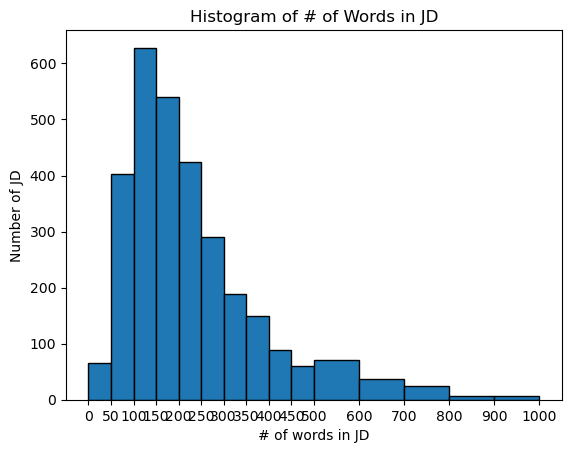

In [50]:
words_in_jd = []
for jd in df['job_description']:
    words_in_jd.append(len(jd.split()))

    
bin_edges = [0,50,100,150,200,250,300,350,400,450,500,600,700,800,900,1000]
plt.hist(words_in_jd, bins = bin_edges, density=False, histtype='bar', edgecolor='k')



plt.xlabel('# of words in JD')
plt.xticks([0,50,100,150,200,250,300,350,400,450,500,600,700,800,900,1000])
plt.ylabel('Number of JD')
plt.title('Histogram of # of Words in JD')

plt.show()



In [51]:
df['job_description'] = df['job_description'].map(remove_stopwords)
df['job_description'] = df['job_description'].map(lemmatize)
df['job_description'] = df['job_description'].map(clean_non_letter)

In [52]:
df['job_description'][0]

'roles responsibilities job role description responsible business development freight forwarding identify potential client target market complete appropriate research prospective client s business equipment need develop intervention strategy mitigate gap delivery logistic service develop relationship potential customer meet sale target negotiate contract term client actively seek new sale opportunity cold calling network social medium requirement proven work experience business development sale executive relevant role experience customer support plus proficiency ms office market knowledge'

In [53]:
df['job_description'][1]

'roles responsibilities job scope spectrum secretarial support ceo provide support daily activity ceo include email meet arrangement handle travel arrangement flight reservation hotel accommodation visa application etc handle confidential information maintain security ceo record file facilitate meeting manage conference schedule refreshment venue teleconference minute etc ceo manage ceo calendar set meeting appointment organize agenda attendance list maintain ceo office accounting record monitor review approve standard expenditure ensure activity office conduct budget instruction respond email letter travel require co ordinates ceo s personal matter include flight housing banking matter assign time time ceo corporate matter assign ceo requirement candidate possess high secondary pre u a level college professional certificate nitec diploma advanced high graduate diploma field year s work experience relate field require position preferably senior executive specialize secretarial executiv

In [54]:
df[['job_id','raw_job_title','job_title','job_description','date_posted','company_name','job_category']].to_csv('exel_04_clean_job_posting_lemmantize_no_stopword.csv')

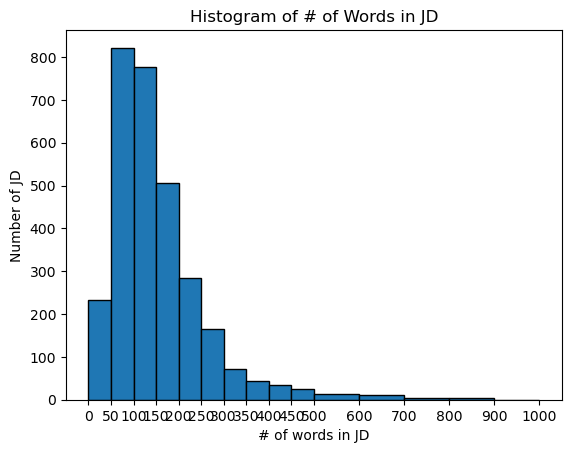

In [55]:
words_in_jd = []
for jd in df['job_description']:
    words_in_jd.append(len(jd.split()))

    
bin_edges = [0,50,100,150,200,250,300,350,400,450,500,600,700,800,900,1000]
plt.hist(words_in_jd, bins = bin_edges, density=False, histtype='bar', edgecolor='k')



plt.xlabel('# of words in JD')
plt.xticks([0,50,100,150,200,250,300,350,400,450,500,600,700,800,900,1000])
plt.ylabel('Number of JD')
plt.title('Histogram of # of Words in JD')

plt.show()



### Duplicate job postings

This code snippet is used to determine whether any two job postings are a duplicate of each other or not.
It make use of cosine similarity between the job description of the two postings.
In order to minimize the search time, it will only compare postings that were posted up to 15 days before.
In addition to that, it will also look at the length of description and filter out the postings that have absolute difference of greater than 1%. 

In [56]:
# # THIS CODE WORK BUT TAKE 18 minutes to run

# def get_difference(date1, date2):
#     delta = date2 - date1
#     return delta.days

# for index, row in tqdm(df.iterrows()):
#     main_index = index
#     main_job_title  = row['job_title']
#     main_company_name = row['company_name']
#     main_date_posted = row['date_posted']
#     main_jd = row['job_description']
#     main_jd_nlp = nlp(main_jd)
#     for index_2, row_2 in df.iterrows():
#         if main_index != index_2:
#             another_date_posted = row_2['date_posted']
#             ### only look at postings that have been posted within the last 15 days
#             if get_difference(main_date_posted,another_date_posted) < 1:
#                 if get_difference(main_date_posted,another_date_posted) > -15:
                    
#                     another_jd = row_2['job_description']
                    
#                     if abs(len(main_jd)-len(another_jd)) < 0.01*len(main_jd): 
     
#                         another_jd_nlp = nlp(another_jd)
        
#                         if main_jd_nlp.similarity(another_jd_nlp) > 0.995:
            
#                             another_job_title = row_2['job_title']
#                             another_company_name = row_2['company_name']
                        
#                             print(f"JD {index} and {index_2} has similarity of {main_jd_nlp.similarity(another_jd_nlp)}. Please check for duplication")
#                             print(main_job_title,'--', main_company_name,'--',main_date_posted,'--', main_jd[0:100])
#                             print(another_job_title,'--', another_company_name,'--', another_date_posted,'--',another_jd[0:100])
#                             print(f"\n")

43it [00:14,  3.96it/s]

JD 42 and 1136 has similarity of 1.0. Please check for duplication
soc analyst -- ember recruitment pte ltd -- 2020-11-09 00:00:00 -- client highly establish bank seek x information security analyst junior senior join soc team success
l1 / l2 soc analyst -- ember recruitment pte ltd -- 2020-11-09 00:00:00 -- client highly establish bank seek x information security analyst junior senior join soc team success




188it [01:04,  2.76it/s]

JD 188 and 828 has similarity of 1.0. Please check for duplication
inventory manager / -- achieve career consultant pte ltd -- 2020-11-25 00:00:00 -- till high bonus day work week experience sap liaise japanese speak customer year experience similar 
inventory manager / -- achieve career consultant pte ltd -- 2020-11-22 00:00:00 -- till high bonus day work week experience sap liaise japanese speak customer year experience similar 




194it [01:06,  3.15it/s]

JD 193 and 2128 has similarity of 0.9989650359456617. Please check for duplication
sql developer -- technopals pte ltd -- 2020-11-25 00:00:00 -- roles responsibilities skill qualification requirements in depth knowledge sql server experience mic
sql developer -- people profilers (services) pte ltd -- 2020-11-25 00:00:00 -- roles responsibilities skill qualification requirements in depth knowledge sql server experience mic




267it [01:32,  2.55it/s]

JD 267 and 1290 has similarity of 1.0. Please check for duplication
senior/ application consultant -- central provident fund board -- 2020-11-24 00:00:00 -- information technology system form backbone operation look individual passion expertise help improve
senior/ application consultant -- central provident fund board -- 2020-11-11 00:00:00 -- information technology system form backbone operation look individual passion expertise help improve




397it [02:20,  3.35it/s]

JD 396 and 1326 has similarity of 1.0. Please check for duplication
digital marketing intern -- tech2reachtech2reach -- 2020-11-13 00:00:00 -- marketing especially digital marketing important aspect business have right skillset marketing combi
digital marketing intern -- tech2reachtech2reach -- 2020-11-03 00:00:00 -- marketing especially digital marketing important aspect business have right skillset marketing combi




542it [03:15,  2.37it/s]

JD 541 and 1842 has similarity of 1.0. Please check for duplication
finance executive employment and employability institute -- confidential -- 2020-11-18 00:00:00 -- finance executive corporate finance team report finance deputy director work closely stakeholder int
finance executive employment and employability institute -- confidential -- 2020-11-12 00:00:00 -- finance executive corporate finance team report finance deputy director work closely stakeholder int




548it [03:16,  3.30it/s]

JD 547 and 1325 has similarity of 0.9962450913947156. Please check for duplication
head cook -- woods cafe pte ltd -- 2020-11-25 00:00:00 -- roles responsibilities head cook responsible go employer kitchen require oversee dish start finish t
chief cook -- haji syed eating house pte ltd -- 2020-11-25 00:00:00 -- roles responsibilities chief cook responsible go employer kitchen require oversee dish start finish 




679it [04:02,  3.03it/s]

JD 678 and 520 has similarity of 1.0. Please check for duplication
clinic receptionist/ pharmacy apprentice -- recruitexpress -- 2020-12-23 00:00:00 -- assist pharmacist dispensing supply drug chemical outpatient inpatient retail section assist pharmac
pharmacy assistant/clinic assistant -- recruitexpress -- 2020-12-09 00:00:00 -- assist pharmacist dispensing supply drug chemical outpatient inpatient retail section assist pharmac




758it [04:28,  3.11it/s]

JD 758 and 964 has similarity of 0.9955038027123435. Please check for duplication
spa therapist -- imperial apple spa @ orchard pte ltd -- 2020-11-26 00:00:00 -- roles responsibilities job description provide consistent professional spa massage either body foot 
beautician -- a new u beauty & wellness -- 2020-11-21 00:00:00 -- roles responsibilities job description provide beauty spa massage service confirm high standard serv




797it [04:44,  2.58it/s]

JD 796 and 1930 has similarity of 1.0. Please check for duplication
service -- confidential -- 2020-11-27 00:00:00 -- han s cafe cake house pte ltdjob details time hr min week service crew able perform main duty main d
service crew -- confidential -- 2020-11-27 00:00:00 -- han s cafe cake house pte ltdjob details time hr min week service crew able perform main duty main d




934it [05:35,  2.14it/s]

JD 933 and 1080 has similarity of 0.9996908503847171. Please check for duplication
sales personnel customers provided -- locanto -- 2020-11-18 00:00:00 -- position sales personnel client relationship marketing salary comm need find customer interested cus
sales service personnel customers fully providedclient relationship business marketing -- recruitment express -- 2020-11-09 00:00:00 -- roles responsibilities salary comm sales personnel client relationship marketing need find customer 




1072it [06:23,  2.53it/s]

JD 1071 and 2067 has similarity of 1.0. Please check for duplication
customer service ambassador -- kelly services (s) pte ltd -- 2020-11-18 00:00:00 -- job description ensure enter booth counter adhere safe distancing measure safe entry check in safe d
customer service ambassador -- kelly services (s) pte ltd -- 2020-11-12 00:00:00 -- job description ensure enter booth counter adhere safe distancing measure safe entry check in safe d




1078it [06:25,  3.18it/s]

JD 1078 and 526 has similarity of 1.0. Please check for duplication
product manager -- recruitplus consulting pte ltd -- 2020-11-20 00:00:00 -- basic aws vb mnc mobile app mondayfriday day paya lebar mrt client tech firm design produce mobile a
product manager -- recruitplus consulting pte ltd -- 2020-11-17 00:00:00 -- basic aws vb mnc mobile app mondayfriday day paya lebar mrt client tech firm design produce mobile a




1137it [06:45,  3.46it/s]

JD 1136 and 42 has similarity of 1.0. Please check for duplication
l1 / l2 soc analyst -- ember recruitment pte ltd -- 2020-11-09 00:00:00 -- client highly establish bank seek x information security analyst junior senior join soc team success
soc analyst -- ember recruitment pte ltd -- 2020-11-09 00:00:00 -- client highly establish bank seek x information security analyst junior senior join soc team success




1138it [06:45,  2.78it/s]

JD 1138 and 188 has similarity of 1.0. Please check for duplication
inventory manager / -- achieve career consultant pte ltd -- 2020-11-26 00:00:00 -- till high bonus day work week experience sap liaise japanese speak customer year experience similar 
inventory manager / -- achieve career consultant pte ltd -- 2020-11-25 00:00:00 -- till high bonus day work week experience sap liaise japanese speak customer year experience similar 


JD 1138 and 828 has similarity of 1.0. Please check for duplication
inventory manager / -- achieve career consultant pte ltd -- 2020-11-26 00:00:00 -- till high bonus day work week experience sap liaise japanese speak customer year experience similar 
inventory manager / -- achieve career consultant pte ltd -- 2020-11-22 00:00:00 -- till high bonus day work week experience sap liaise japanese speak customer year experience similar 




1262it [07:27,  3.33it/s]

JD 1261 and 1959 has similarity of 0.9979731462529611. Please check for duplication
temp patient service associate / contract dental assistant hsj -- recruitexpress -- 2020-12-20 00:00:00 -- job scope providing frontline customer service handle counter registration scheduling appointment co
clinic assistant / healthcare customer service associate hsj -- recruitexpress -- 2020-12-11 00:00:00 -- job scope providing frontline customer service handle counter registration scheduling appointment co




1304it [07:41,  2.92it/s]

JD 1303 and 2944 has similarity of 0.9993797209339046. Please check for duplication
consultant, systems -- ncs -- 2020-11-18 00:00:00 -- ncs lead information communication technology ict communication engineering service provider asia pa
engineer -- ncs -- 2020-11-18 00:00:00 -- ncs lead information communication technology ict communication engineering service provider asia pa




1325it [07:48,  2.34it/s]

JD 1325 and 547 has similarity of 0.9962450913947156. Please check for duplication
chief cook -- haji syed eating house pte ltd -- 2020-11-25 00:00:00 -- roles responsibilities chief cook responsible go employer kitchen require oversee dish start finish 
head cook -- woods cafe pte ltd -- 2020-11-25 00:00:00 -- roles responsibilities head cook responsible go employer kitchen require oversee dish start finish t




1678it [09:53,  2.76it/s]

JD 1677 and 1919 has similarity of 0.99990635981308. Please check for duplication
site supervisor / foremen -- accesstech engineering pte ltd -- 2020-11-10 00:00:00 -- roles responsibilities role responsibility plan lead group worker perform project work assign projec
site supervisor -- otc construction engineering pte ltd -- 2020-11-10 00:00:00 -- roles responsibilities roles responsibilities plan lead group worker perform project work assign pro




1680it [09:54,  2.91it/s]

JD 1680 and 1552 has similarity of 0.9997555488665107. Please check for duplication
pharmaceutical sales representative -- recruit express pte ltd -- 2020-11-26 00:00:00 -- job description work sophisticated audience comprise surgeon healthcare professional communicate cus
pharmaceutical sales representative -- recruit express pte ltd -- 2020-11-19 00:00:00 -- job description work sophisticated audience comprise surgeon healthcare professional communicate cus




1884it [11:07,  4.04it/s]

JD 1883 and 2911 has similarity of 1.0. Please check for duplication
qa/qc technician -- recruit expert pte ltd -- 2020-11-20 00:00:00 -- roles responsibilities responsibility responsible handle incoming outcome inspection manufacture flo
qa/qc technician -- recruit expert pte ltd -- 2020-11-17 00:00:00 -- roles responsibilities responsibility responsible handle incoming outcome inspection manufacture flo




1896it [11:10,  3.08it/s]

JD 1896 and 1255 has similarity of 1.0. Please check for duplication
preclinical imaging scientist/operator/specialist -- national university of singapore -- 2020-11-20 00:00:00 -- candidate expect establish new preclinical acquisition protocol t mri scanner order meet increase de
preclinical imaging scientist/operator/specialist -- national university of singapore -- 2020-11-14 00:00:00 -- candidate expect establish new preclinical acquisition protocol t mri scanner order meet increase de




1920it [11:19,  2.81it/s]

JD 1919 and 1677 has similarity of 0.99990635981308. Please check for duplication
site supervisor -- otc construction engineering pte ltd -- 2020-11-10 00:00:00 -- roles responsibilities roles responsibilities plan lead group worker perform project work assign pro
site supervisor / foremen -- accesstech engineering pte ltd -- 2020-11-10 00:00:00 -- roles responsibilities role responsibility plan lead group worker perform project work assign projec




1931it [11:22,  4.72it/s]

JD 1930 and 796 has similarity of 1.0. Please check for duplication
service crew -- confidential -- 2020-11-27 00:00:00 -- han s cafe cake house pte ltdjob details time hr min week service crew able perform main duty main d
service -- confidential -- 2020-11-27 00:00:00 -- han s cafe cake house pte ltdjob details time hr min week service crew able perform main duty main d




1957it [11:33,  2.24it/s]

JD 1957 and 158 has similarity of 1.0. Please check for duplication
section manager, payroll & claims -- vital -- 2020-11-18 00:00:00 -- section manager payroll claim lead team senior executive executives handle payroll claim processing 
section manager, payroll & claims -- vital -- 2020-11-04 00:00:00 -- section manager payroll claim lead team senior executive executives handle payroll claim processing 




2075it [12:13,  3.24it/s]

JD 2075 and 1204 has similarity of 1.0. Please check for duplication
sales executive -- confidential -- 2020-11-25 00:00:00 -- membership executive evolve mma positively impact people s life commitment self improvement achieve 
membership executive -- confidential -- 2020-11-12 00:00:00 -- membership executive evolve mma positively impact people s life commitment self improvement achieve 




2128it [12:34,  3.18it/s]

JD 2128 and 193 has similarity of 0.9989650359456617. Please check for duplication
sql developer -- people profilers (services) pte ltd -- 2020-11-25 00:00:00 -- roles responsibilities skill qualification requirements in depth knowledge sql server experience mic
sql developer -- technopals pte ltd -- 2020-11-25 00:00:00 -- roles responsibilities skill qualification requirements in depth knowledge sql server experience mic




2198it [12:56,  3.89it/s]

JD 2197 and 1124 has similarity of 1.0. Please check for duplication
temp admin assistant training provided -- recruitexpress -- 2020-12-17 00:00:00 -- assist department maintain attendance tracking report datum management medical report planning meeti
temp admin assistant training provided -- recruitexpress -- 2020-12-16 00:00:00 -- assist department maintain attendance tracking report datum management medical report planning meeti




2203it [12:58,  3.19it/s]

JD 2203 and 638 has similarity of 1.0. Please check for duplication
specialist, d.c site operations dnh -- capita pte ltd - engineering -- 2020-11-19 00:00:00 -- responsibility work rotate shift support datum centre onsite operation critical facility strong desi
specialist, d.c site operations dnh -- capita pte ltd - engineering -- 2020-11-13 00:00:00 -- responsibility work rotate shift support datum centre onsite operation critical facility strong desi




2212it [13:01,  2.02it/s]

JD 2211 and 2775 has similarity of 1.0. Please check for duplication
preschool reading & writing teacher -- mindchamps preschool @ buangkok pte ltd -- 2020-11-23 00:00:00 -- roles responsibilities join dream team discover champion you mindchampion leader join premium presch
preschool reading & writing teacher -- mindchamps preschool @ marina square pte ltd -- 2020-11-23 00:00:00 -- roles responsibilities join dream team discover champion you mindchampion leader join premium presch




2222it [13:06,  2.54it/s]

JD 2222 and 225 has similarity of 1.0. Please check for duplication
corporate sales executive -- oom pte ltd -- 2020-11-19 00:00:00 -- role statement corporate sale hunter role require acquire new client digital marketing solution basi
corporate sales executive -- oom pte ltd -- 2020-11-10 00:00:00 -- role statement corporate sale hunter role require acquire new client digital marketing solution basi




2324it [13:41,  2.92it/s]

JD 2323 and 2354 has similarity of 1.0. Please check for duplication
it support engineer | no experience is required | salary from to -- primestaff management services pte ltd -- 2020-11-26 00:00:00 -- responsibility maintain support laptop desktop provide level troubleshoot wireless printer scanner i
it support engineer | no experience is required | salary from to -- primestaff management services pte ltd -- 2020-11-21 00:00:00 -- responsibility maintain support laptop desktop provide level troubleshoot wireless printer scanner i




2492it [14:39,  2.36it/s]

JD 2491 and 2823 has similarity of 1.0. Please check for duplication
toolmaker -- recruit expert pte ltd -- 2020-11-26 00:00:00 -- roles responsibilities responsibility responsible perform assembly debug press tool requirement min 
toolmaker -- recruit expert pte ltd -- 2020-11-19 00:00:00 -- roles responsibilities responsibility responsible perform assembly debug press tool requirement min 




2556it [15:02,  3.62it/s]

JD 2556 and 336 has similarity of 1.0. Please check for duplication
hr manager / east / -- capita pte ltd - business support 2 -- 2020-11-15 00:00:00 -- job descriptionresponsible spectrum human resource function include manpower planning recruitment se
hr manager / east / -- capita pte ltd - business support 2 -- 2020-11-09 00:00:00 -- job descriptionresponsible spectrum human resource function include manpower planning recruitment se




2736it [16:06,  3.47it/s]

JD 2736 and 1498 has similarity of 1.0. Please check for duplication
order management team lead , -- recruit express pte ltd -- 2020-11-14 00:00:00 -- responsibility elevate service consumer maximize inventory productivity collaboration external inter
regional order fulfillment executive , -- recruit express pte ltd -- 2020-11-09 00:00:00 -- responsibility elevate service consumer maximize inventory productivity collaboration external inter




2776it [16:21,  2.13it/s]

JD 2775 and 2211 has similarity of 1.0. Please check for duplication
preschool reading & writing teacher -- mindchamps preschool @ marina square pte ltd -- 2020-11-23 00:00:00 -- roles responsibilities join dream team discover champion you mindchampion leader join premium presch
preschool reading & writing teacher -- mindchamps preschool @ buangkok pte ltd -- 2020-11-23 00:00:00 -- roles responsibilities join dream team discover champion you mindchampion leader join premium presch




2779it [16:22,  2.30it/s]

JD 2778 and 2861 has similarity of 1.0. Please check for duplication
gross armed officer certis group -- confidential -- 2020-11-21 00:00:00 -- armed auxiliary police officers bonus gross auxiliary police officer train handle wide range securit
gross direct entry cpl/sgt whatsapp certis group -- confidential -- 2020-11-12 00:00:00 -- armed auxiliary police officers bonus gross auxiliary police officer train handle wide range securit




2883it [16:58,  2.54it/s]

JD 2882 and 2192 has similarity of 1.0. Please check for duplication
process engineer -- koch industries, inc -- 2020-11-19 00:00:00 -- description rolebe responsible pre order evaluation design estimation technical solution meet custom
process engineer -- koch industries, inc -- 2020-11-11 00:00:00 -- description rolebe responsible pre order evaluation design estimation technical solution meet custom




2945it [17:20,  2.52it/s]

JD 2944 and 1303 has similarity of 0.9993797209339046. Please check for duplication
engineer -- ncs -- 2020-11-18 00:00:00 -- ncs lead information communication technology ict communication engineering service provider asia pa
consultant, systems -- ncs -- 2020-11-18 00:00:00 -- ncs lead information communication technology ict communication engineering service provider asia pa




2971it [17:29,  3.16it/s]

JD 2970 and 2279 has similarity of 1.0. Please check for duplication
qc inspector -- persol singapore (a division of capita pte ltd) -- 2020-11-19 00:00:00 -- well establish mnc company look talent quality control technician otj provide job responsibility per
qc inspector -- persol singapore (a division of capita pte ltd) -- 2020-11-13 00:00:00 -- well establish mnc company look talent quality control technician otj provide job responsibility per




3000it [17:40,  2.83it/s]


### All job tops key words

In [57]:
## Functions to generate 2-grams, 3-grams, and 4-grams words.
def generate_2_grams(text,ngram=2):
    words=[word for word in text.split(" ")]
    temp = zip(*[words[i:] for i in range(0,ngram)])
    ans=['_'.join(ngram) for ngram in temp]
    return ' '.join(ans)

def generate_3_grams(text,ngram=3):
    words=[word for word in text.split(" ")]
    temp = zip(*[words[i:] for i in range(0,ngram)])
    ans=['_'.join(ngram) for ngram in temp]
    return ' '.join(ans)

def generate_4_grams(text,ngram=4):
    words=[word for word in text.split(" ")]
    temp = zip(*[words[i:] for i in range(0,ngram)])
    ans=['_'.join(ngram) for ngram in temp]
    return ' '.join(ans)


In [58]:
frequency_counter(df['job_description'],50)

[('work', 5508),
 ('experience', 5133),
 ('team', 3616),
 ('management', 2994),
 ('skill', 2835),
 ('business', 2767),
 ('project', 2602),
 ('ensure', 2539),
 ('support', 2495),
 ('customer', 2468),
 ('job', 2458),
 ('good', 2359),
 ('requirement', 2278),
 ('provide', 2231),
 ('service', 2172),
 ('year', 2154),
 ('candidate', 1911),
 ('system', 1875),
 ('process', 1846),
 ('development', 1738),
 ('product', 1719),
 ('include', 1690),
 ('manage', 1690),
 ('able', 1686),
 ('knowledge', 1684),
 ('client', 1667),
 ('application', 1598),
 ('responsibility', 1566),
 ('communication', 1552),
 ('strong', 1478),
 ('design', 1461),
 ('develop', 1454),
 ('relate', 1340),
 ('require', 1339),
 ('new', 1338),
 ('report', 1304),
 ('apply', 1298),
 ('ability', 1289),
 ('company', 1276),
 ('technology', 1264),
 ('degree', 1247),
 ('datum', 1244),
 ('relevant', 1196),
 ('perform', 1195),
 ('maintain', 1192),
 ('responsibilities', 1182),
 ('s', 1175),
 ('resume', 1171),
 ('technical', 1155),
 ('assist', 

In [59]:
frequency_counter(df['job_description'].map(generate_2_grams),50)

[('roles_responsibilities', 940),
 ('communication_skill', 702),
 ('able_work', 563),
 ('year_experience', 558),
 ('work_experience', 535),
 ('and_or', 523),
 ('pte_ltd', 490),
 ('team_player', 465),
 ('minimum_year', 433),
 ('shortlist_candidate', 417),
 ('job_description', 406),
 ('ad_hoc', 395),
 ('work_closely', 393),
 ('year_relevant', 389),
 ('customer_service', 377),
 ('interpersonal_skill', 369),
 ('candidate_notify', 358),
 ('e_g', 354),
 ('duty_assign', 345),
 ('interested_candidate', 318),
 ('work_independently', 314),
 ('relevant_experience', 303),
 ('project_management', 277),
 ('computer_science', 270),
 ('problem_solve', 270),
 ('good_communication', 262),
 ('fast_pace', 257),
 ('add_advantage', 251),
 ('job_requirements', 251),
 ('ability_work', 247),
 ('update_resume', 246),
 ('job_requirement', 245),
 ('license_no', 243),
 ('interested_applicant', 242),
 ('internal_external', 242),
 ('working_experience', 242),
 ('ea_license', 236),
 ('ms_word', 236),
 ('relate_field'

In [60]:
frequency_counter(df['job_description'].map(generate_3_grams),50)

[('shortlist_candidate_notify', 317),
 ('year_work_experience', 221),
 ('regret_shortlist_candidate', 204),
 ('ad_hoc_duty', 198),
 ('year_relevant_experience', 191),
 ('pte_ltd_ea', 186),
 ('resume_ms_word', 180),
 ('able_work_independently', 177),
 ('communication_interpersonal_skill', 175),
 ('fast_pace_environment', 169),
 ('ms_word_format', 168),
 ('roles_responsibilities_job', 163),
 ('ea_license_no', 159),
 ('bachelor_s_degree', 137),
 ('problem_solve_skill', 137),
 ('interpersonal_communication_skill', 134),
 ('hoc_duty_assign', 134),
 ('roles_responsibilities_responsibility', 127),
 ('minimum_year_experience', 127),
 ('relevant_working_experience', 126),
 ('good_communication_skill', 123),
 ('day_work_week', 120),
 ('express_pte_ltd', 118),
 ('write_communication_skill', 116),
 ('recruit_express_pte', 110),
 ('year_relevant_working', 110),
 ('hand_on_experience', 110),
 ('update_resume_ms', 106),
 ('minimum_year_relevant', 105),
 ('degree_computer_science', 105),
 ('candidate_

In [61]:
frequency_counter(df['job_description'].map(generate_4_grams),50)

[('regret_shortlist_candidate_notify', 161),
 ('resume_ms_word_format', 138),
 ('ad_hoc_duty_assign', 134),
 ('year_relevant_working_experience', 107),
 ('interested_candidate_wish_apply', 99),
 ('recruit_express_pte_ltd', 99),
 ('email_update_copy_resume', 97),
 ('roles_responsibilities_job_description', 94),
 ('wish_apply_advertised_position', 92),
 ('candidate_wish_apply_advertised', 86),
 ('pte_ltd_ea_license', 85),
 ('regret_inform_shortlist_candidate', 85),
 ('good_communication_interpersonal_skill', 85),
 ('work_experience_relate_field', 80),
 ('update_resume_ms_word', 74),
 ('express_pte_ltd_ea', 72),
 ('work_fast_pace_environment', 68),
 ('pte_ltd_ea_licence', 67),
 ('inform_shortlist_candidate_notify', 66),
 ('write_verbal_communication_skill', 65),
 ('good_interpersonal_communication_skill', 63),
 ('datum_and_or_resume', 63),
 ('personal_datum_and_or', 62),
 ('minimum_year_work_experience', 59),
 ('diploma_advanced_high_graduate', 58),
 ('we_regret_shortlist_candidate', 58),

In [62]:
FD_N = 100
for category in job_category_in_df:
    print(category,' ------> ',len(df['job_description'][df['job_category']==category]),f"posting(s)")
    print(f"\n")
    FD = frequency_counter(df['job_description'][df['job_category']==category],FD_N)
    print(FD)
    print(f"\n")
    FD = frequency_counter(df['job_description'][df['job_category']==category].map(generate_2_grams),FD_N)
    print(FD)
    print(f"\n")
    FD = frequency_counter(df['job_description'][df['job_category']==category].map(generate_3_grams),FD_N)
    print(FD)
    print(f"\n")
    FD = frequency_counter(df['job_description'][df['job_category']==category].map(generate_4_grams),FD_N)
    print(FD)
    print(f"\n")

finance|financial|bank  ------>  99 posting(s)


[('financial', 201), ('team', 185), ('business', 184), ('experience', 178), ('work', 166), ('management', 150), ('finance', 120), ('client', 119), ('requirement', 108), ('skill', 106), ('banking', 98), ('ensure', 96), ('singapore', 95), ('bank', 92), ('product', 91), ('support', 88), ('good', 86), ('accounting', 84), ('customer', 84), ('knowledge', 82), ('process', 80), ('ltd', 80), ('project', 79), ('provide', 77), ('year', 77), ('strong', 77), ('service', 76), ('job', 73), ('system', 71), ('development', 69), ('company', 68), ('report', 67), ('manage', 66), ('communication', 64), ('new', 63), ('ability', 63), ('include', 61), ('able', 60), ('review', 59), ('prepare', 59), ('responsibility', 56), ('assist', 56), ('group', 54), ('role', 54), ('lead', 54), ('technology', 54), ('account', 54), ('stakeholder', 53), ('datum', 53), ('investment', 53), ('degree', 52), ('candidate', 52), ('internal', 51), ('drive', 50), ('audit', 49), ('analysi

[('shortlist_candidate_notify', 120), ('roles_responsibilities_job', 81), ('regret_shortlist_candidate', 73), ('ad_hoc_duty', 72), ('able_work_independently', 68), ('year_relevant_experience', 66), ('communication_interpersonal_skill', 65), ('year_work_experience', 61), ('pte_ltd_ea', 60), ('resume_ms_word', 55), ('ms_word_format', 54), ('hoc_duty_assign', 53), ('fast_pace_environment', 50), ('ea_license_no', 49), ('roles_responsibilities_responsibility', 49), ('relevant_working_experience', 48), ('day_work_week', 46), ('responsibilities_job_description', 45), ('interpersonal_communication_skill', 44), ('good_communication_skill', 43), ('update_copy_resume', 42), ('current_expect_salary', 42), ('year_relevant_working', 42), ('candidate_wish_apply', 41), ('email_update_copy', 41), ('minimum_year_relevant', 40), ('interested_candidate_wish', 38), ('bachelor_s_degree', 38), ('write_communication_skill', 38), ('click_apply_now', 37), ('minimum_year_experience', 37), ('problem_solve_skill',

[('degree_computer_science', 19), ('bachelor_s_degree', 16), ('year_relevant_experience', 14), ('hand_on_experience', 13), ('computer_science_information', 12), ('minimum_year_experience', 12), ('ea_license_no', 12), ('shortlist_candidate_notify', 11), ('resume_ms_word', 11), ('ms_word_format', 11), ('science_information_technology', 10), ('pte_ltd_ea', 10), ('year_work_experience', 10), ('end_to_end', 10), ('write_communication_skill', 10), ('strong_analytical_skill', 9), ('problem_solve_skill', 9), ('development_life_cycle', 8), ('ability_work_independently', 8), ('kelly_services_singapore', 8), ('services_singapore_pte', 8), ('singapore_pte_ltd', 8), ('pte_ltd_persolkelly', 8), ('disclose_personal_datum', 8), ('user_acceptance_testing', 7), ('technical_skills_competencies', 7), ('communication_skill_ability', 7), ('communication_interpersonal_skill', 7), ('click_apply_now', 7), ('regret_shortlist_candidate', 7), ('verbal_write_communication', 7), ('equal_opportunity_employer', 7), (

[('year_relevant_working_experience', 19), ('resume_ms_word_format', 13), ('work_fast_pace_environment', 12), ('update_resume_ms_word', 11), ('email_update_copy_resume', 10), ('minimum_year_work_experience', 9), ('regret_shortlist_candidate_notify', 9), ('wish_apply_advertised_position', 9), ('short_list_candidate_notify', 8), ('ea_personnel_reg_no', 8), ('year_experience_similar_industry', 8), ('experience_similar_industry_similar', 8), ('similar_industry_similar_position', 8), ('end_to_end_product', 8), ('write_verbal_communication_skill', 8), ('roles_responsibilities_job_description', 8), ('candidate_wish_apply_advertised', 8), ('good_interpersonal_communication_skill', 7), ('regret_short_list_candidate', 7), ('submit_application_email_detailed', 7), ('application_email_detailed_copy', 7), ('email_detailed_copy_update', 7), ('detailed_copy_update_resume', 7), ('copy_update_resume_ms', 7), ('strong_project_management_skill', 7), ('liaise_japanese_speak_customer', 7), ('year_relevant_

### Skill Extraction vs Frequencey Count

In [63]:
def extract_to_list_top_1gram_keyword(job_category,top_word=100):
    temp = []
    temp_counter = frequency_counter(df['job_description'][df['job_category']==job_category],top_word)
    for token in temp_counter:
        temp.append(token[0])
    return temp

top_1gram_other =  extract_to_list_top_1gram_keyword('other')
top_1gram_engineer = extract_to_list_top_1gram_keyword('engineer')
top_1gram_manager = extract_to_list_top_1gram_keyword('manager')
top_1gram_marketing = extract_to_list_top_1gram_keyword('marketing|market|sales')
top_1gram_analytic = extract_to_list_top_1gram_keyword('analytic|analyst|data')
top_1gram_admin = extract_to_list_top_1gram_keyword('admin')
top_1gram_account= extract_to_list_top_1gram_keyword('account')
top_1gram_health = extract_to_list_top_1gram_keyword('healthcare|medical|nurse|hospital|pharma|clinic|patient')
top_1gram_customer = extract_to_list_top_1gram_keyword('customer|service|call')
top_1gram_finance = extract_to_list_top_1gram_keyword('finance|financial|bank')
top_1gram_software = extract_to_list_top_1gram_keyword('software|developer|java|network|system')
top_1gram_hr = extract_to_list_top_1gram_keyword('hr|human')
top_1gram_technician = extract_to_list_top_1gram_keyword('technician')
top_1gram_chef =  extract_to_list_top_1gram_keyword('chef|cook|kitchen|barista|bartender|restaurant')

In [64]:
def extract_to_list_top_2gram_keyword(job_category,top_word=100):
    temp = []
    temp_counter = frequency_counter(df['job_description'][df['job_category']==job_category].map(generate_2_grams),top_word)
    for token in temp_counter:
        temp.append(token[0])
    return temp

top_2gram_other =  extract_to_list_top_2gram_keyword('other')
top_2gram_engineer = extract_to_list_top_2gram_keyword('engineer')
top_2gram_manager = extract_to_list_top_2gram_keyword('manager')
top_2gram_marketing = extract_to_list_top_2gram_keyword('marketing|market|sales')
top_2gram_analytic = extract_to_list_top_2gram_keyword('analytic|analyst|data')
top_2gram_admin = extract_to_list_top_2gram_keyword('admin')
top_2gram_account= extract_to_list_top_2gram_keyword('account')
top_2gram_health = extract_to_list_top_2gram_keyword('healthcare|medical|nurse|hospital|pharma|clinic|patient')
top_2gram_customer = extract_to_list_top_2gram_keyword('customer|service|call')
top_2gram_finance = extract_to_list_top_2gram_keyword('finance|financial|bank')
top_2gram_software = extract_to_list_top_2gram_keyword('software|developer|java|network|system')
top_2gram_hr = extract_to_list_top_2gram_keyword('hr|human')
top_2gram_technician = extract_to_list_top_2gram_keyword('technician')
top_2gram_chef =  extract_to_list_top_2gram_keyword('chef|cook|kitchen|barista|bartender|restaurant')

In [65]:
def extract_to_list_top_3gram_keyword(job_category,top_word=100):
    temp = []
    temp_counter = frequency_counter(df['job_description'][df['job_category']==job_category].map(generate_3_grams),top_word)
    for token in temp_counter:
        temp.append(token[0])
    return temp


top_3gram_other =  extract_to_list_top_3gram_keyword('other')
top_3gram_engineer = extract_to_list_top_3gram_keyword('engineer')
top_3gram_manager = extract_to_list_top_3gram_keyword('manager')
top_3gram_marketing = extract_to_list_top_3gram_keyword('marketing|market|sales')
top_3gram_analytic = extract_to_list_top_3gram_keyword('analytic|analyst|data')
top_3gram_admin = extract_to_list_top_3gram_keyword('admin')
top_3gram_account= extract_to_list_top_3gram_keyword('account')
top_3gram_health = extract_to_list_top_3gram_keyword('healthcare|medical|nurse|hospital|pharma|clinic|patient')
top_3gram_customer = extract_to_list_top_3gram_keyword('customer|service|call')
top_3gram_finance = extract_to_list_top_3gram_keyword('finance|financial|bank')
top_3gram_software = extract_to_list_top_3gram_keyword('software|developer|java|network|system')
top_3gram_hr = extract_to_list_top_3gram_keyword('hr|human')
top_3gram_technician = extract_to_list_top_3gram_keyword('technician')
top_3gram_chef =  extract_to_list_top_3gram_keyword('chef|cook|kitchen|barista|bartender|restaurant')


### For 'healthcare|medical|nurse|hospital|pharma|clinic|patient'

In [66]:

top_1_gram_not_health = top_1gram_other + top_1gram_engineer + top_1gram_manager + top_1gram_marketing + top_1gram_analytic + top_1gram_admin + top_1gram_account + top_1gram_customer + top_1gram_finance + top_1gram_software + top_1gram_hr + top_1gram_technician + top_1gram_chef


In [67]:
top_2gram_not_health = top_2gram_other + top_2gram_engineer + top_2gram_manager + top_2gram_marketing + top_2gram_analytic + top_2gram_admin + top_2gram_account + top_2gram_customer + top_2gram_finance + top_2gram_software + top_2gram_hr + top_2gram_technician + top_2gram_chef

In [68]:
top_3_gram_not_health = top_3gram_other + top_3gram_engineer + top_3gram_manager + top_3gram_marketing + top_3gram_analytic + top_3gram_admin + top_3gram_account + top_3gram_customer + top_3gram_finance + top_3gram_software + top_3gram_hr + top_3gram_technician + top_3gram_chef


In [69]:
unique_1gram_health = []
for token in top_1gram_health:
    if token not in top_1_gram_not_health:
        unique_1gram_health.append(token)


In [70]:
unique_2gram_health = []
for token in top_2gram_health:
    if token not in top_2gram_not_health:
        unique_2gram_health.append(token)

In [71]:
unique_3gram_health = []
for token in top_3gram_health:
    if token not in top_3_gram_not_health:
        unique_3gram_health.append(token)

In [72]:
unique_1gram_health

['patient',
 'nursing',
 'clinical',
 'care',
 'medical',
 'healthcare',
 'clinic',
 'nurse',
 'hospital',
 'license',
 'registration',
 'participate',
 'doctor',
 'medication',
 'com',
 'emailprotecte']

In [73]:
unique_2gram_health

['nursing_care',
 'patient_care',
 'singapore_nursing',
 'nursing_board',
 'degree_nursing',
 'michelle_lee',
 'care_patient',
 'assist_doctor',
 'candidate_send',
 'requirements_min',
 'nitec_diploma',
 'diploma_nursing',
 'staff_nurse',
 'registered_singapore',
 'prior_experience',
 'resume_to',
 'regret_inform',
 'inform_shortlist',
 'rotate_shift',
 'healthcare_industry',
 'image_analysis',
 'clinical_study',
 'clinical_research',
 'registered_nurse',
 'medical_device',
 'confidential_discussion',
 'skill_interested',
 'minimum_supervision',
 'lee_ser',
 'life_science',
 'mri_image',
 'public_health',
 'ltd_company',
 'company_reg',
 'clinical_development',
 'regional_medical',
 'send_recent',
 'recent_update',
 'subject_heading',
 'ser_min',
 'independently_minimum']

In [74]:
unique_3gram_health

['singapore_nursing_board',
 'registered_singapore_nursing',
 'michelle_lee_ser',
 'mri_image_analysis',
 'diploma_degree_nursing',
 'send_resume_to',
 'pte_ltd_company',
 'ltd_company_reg',
 'company_reg_no',
 'candidate_send_recent',
 'send_recent_update',
 'lee_ser_min',
 'work_independently_minimum',
 'independently_minimum_supervision',
 'michelle_lee_recruitexpress',
 'skill_interested_candidate',
 'requirements_min_degree',
 'general_nursing_duty',
 'update_resume_michelle',
 'resume_michelle_lee',
 'com_sg_subject',
 'sg_subject_heading',
 'ser_min_recruit',
 'min_recruit_express',
 'candidate_send_resume',
 'valerie_yong_kian',
 'jenalyn_ooi_huai',
 'ooi_huai_sian',
 'interpersonal_skill_interested',
 'nitec_diploma_degree',
 'resume_to_emailprotecte',
 'nursing_care_patient',
 'work_short_notice',
 'ea_personnel_valerie',
 'personnel_valerie_yong',
 't_mri_protocol',
 'interested_candidate_invite',
 'word_format_to',
 'nitec_diploma_nursing',
 'senior_staff_nurse',
 'nursing_

### For engineer

In [75]:

top_1_gram_not_engineer = top_1gram_other + top_1gram_manager + top_1gram_marketing + top_1gram_analytic + top_1gram_admin + top_1gram_account + top_1gram_health + top_1gram_customer + top_1gram_finance + top_1gram_software + top_1gram_hr + top_1gram_technician + top_1gram_chef


In [76]:
top_2_gram_not_engineer = top_2gram_other + top_2gram_manager + top_2gram_marketing + top_2gram_analytic + top_2gram_admin + top_2gram_account + top_2gram_health + top_2gram_customer + top_2gram_finance + top_2gram_software + top_2gram_hr + top_2gram_technician + top_2gram_chef


In [77]:
top_3_gram_not_engineer = top_3gram_other + top_3gram_manager + top_3gram_marketing + top_3gram_analytic + top_3gram_admin + top_3gram_account + top_3gram_health + top_3gram_customer + top_3gram_finance + top_3gram_software + top_3gram_hr + top_3gram_technician + top_3gram_chef


In [78]:
unique_1gram_engineer = []
for token in top_1gram_engineer:
    if token not in top_1_gram_not_engineer:
        unique_1gram_engineer.append(token)

In [79]:
unique_2gram_engineer = []
for token in top_2gram_engineer:
    if token not in top_2_gram_not_engineer:
        unique_2gram_engineer.append(token)

In [80]:
unique_3gram_engineer = []
for token in top_3gram_engineer:
    if token not in top_3_gram_not_engineer:
        unique_3gram_engineer.append(token)

In [81]:
unique_1gram_engineer

['site',
 'electrical',
 'construction',
 'production',
 'improvement',
 'or',
 'manufacturing',
 'mechanical',
 'specification']

In [82]:
unique_2gram_engineer

['technical_support',
 'provide_technical',
 'mechanical_engineering',
 'electrical_engineering',
 'engineering_equivalent',
 'degree_electrical',
 'm_e',
 'responsibility_responsible',
 'requirement_diploma',
 'continuous_improvement',
 'civil_engineering',
 'sub_contractor',
 'degree_engineering',
 'mechanical_electrical',
 'national_origin',
 'sexual_orientation',
 'application_process',
 'electrical_electronics',
 'analytical_problem',
 'corrective_action',
 'diploma_mechanical',
 'method_statement',
 'engineering_mechanical',
 'degree_civil',
 'entry_level',
 'willing_work',
 'operating_system',
 'hardware_software',
 'ensure_proper',
 'requirements_degree']

In [83]:
unique_3gram_engineer 

['provide_technical_support',
 'request_assistance_application',
 'assistance_application_process',
 'degree_electrical_engineering',
 'diploma_degree_electrical',
 'race_color_religion',
 'color_religion_sex',
 'microns_human_resources',
 'human_resources_department',
 'i_c_scada',
 'process_and_or',
 'degree_civil_engineering',
 'transform_world_use',
 'world_use_information',
 'c_scada_iot',
 'scada_iot_tgm',
 'responsibilities_responsibility_responsible',
 'mechanical_engineering_equivalent',
 'discipline_minimum_year',
 'electrical_electronic_engineering',
 'diploma_mechanical_engineering',
 'min_year_work',
 'recruit_expert_com',
 'requirements_degree_diploma',
 'age_national_origin',
 'engineering_min_year',
 'experience_construction_industry',
 'tool_e_g',
 'requirement_min_diploma',
 'keen_apply_position',
 'apply_position_kindly',
 'position_kindly_email',
 'ms_word_hr',
 'word_hr_recruit',
 'hr_recruit_expert',
 'note_shortlist_candidate',
 'internal_external_customer']

### For analytic|analyst|data

In [84]:
top_1_gram_not_analytic = top_1gram_other + top_1gram_engineer + top_1gram_manager + top_1gram_marketing + top_1gram_admin + top_1gram_account + top_1gram_health + top_1gram_customer + top_1gram_finance + top_1gram_software + top_1gram_hr + top_1gram_technician + top_1gram_chef


In [85]:
top_2_gram_not_analytic = top_2gram_other + top_2gram_engineer + top_2gram_manager + top_2gram_marketing + top_2gram_admin + top_2gram_account + top_2gram_health + top_2gram_customer + top_2gram_finance + top_2gram_software + top_2gram_hr + top_2gram_technician + top_2gram_chef


In [86]:
top_3_gram_not_analytic = top_3gram_other + top_3gram_engineer + top_3gram_manager + top_3gram_marketing + top_3gram_admin + top_3gram_account + top_3gram_health + top_3gram_customer + top_3gram_finance + top_3gram_software + top_3gram_hr + top_3gram_technician + top_3gram_chef

In [87]:
unique_1gram_analytic = []
for token in top_1gram_analytic:
    if token not in top_1_gram_not_analytic:
        unique_1gram_analytic.append(token)

In [88]:
unique_2gram_analytic = []
for token in top_2gram_analytic:
    if token not in top_2_gram_not_analytic:
        unique_2gram_analytic.append(token)

In [89]:
unique_3gram_analytic = []
for token in top_3gram_analytic:
    if token not in top_3_gram_not_analytic:
        unique_3gram_analytic.append(token)

In [90]:
unique_1gram_analytic

['model', 'analytic', 'analyst', 'analytical', 'functional', 'use', 'deliver']

In [91]:
unique_2gram_analytic

['business_analyst',
 'data_quality',
 'end_user',
 'datum_analytic',
 'business_need',
 'data_management',
 'data_science',
 'big_data',
 'datum_analysis',
 'machine_learning',
 'business_user',
 'understand_business',
 'decision_make',
 'datum_science',
 'datum_quality',
 'user_acceptance',
 'datum_source',
 'datum_scientist',
 'business_problem',
 'good_understanding',
 'submit_application',
 'technical_skills',
 'management_system',
 'business_analysis',
 'equal_opportunity',
 'machine_learn',
 'business_stakeholder',
 'support_team',
 'data_stewards',
 'use_case',
 'data_visualization']

In [92]:
unique_3gram_analytic

['kelly_services_singapore',
 'services_singapore_pte',
 'pte_ltd_persolkelly',
 'disclose_personal_datum',
 'technical_skills_competencies',
 'machine_learning_model',
 'capita_pte_ltd',
 'ad_hoc_analysis',
 'graduating_calendar_year',
 'fmo_data_management',
 'calendar_year_university',
 'support_data_stewards',
 'skill_attention_detail',
 'consulting_pte_ltd',
 'business_use_case',
 's_degree_computer',
 'job_requirements_degree',
 'involve_software_development',
 'authoritative_provisioning_point',
 'familiar_soc_process',
 'strong_technical_knowledge',
 'what_be_offer',
 'interested_qualified_candidate',
 'standard_chartered_lead',
 'chartered_lead_international',
 'lead_international_bank',
 'international_bank_focus',
 'bank_focus_help',
 'focus_help_people',
 'help_people_company',
 'people_company_prosper',
 'company_prosper_asia',
 'prosper_asia_africa',
 'asia_africa_middle',
 'africa_middle_east',
 'multi_task_prioritize',
 'good_analytical_skill']

In [93]:
top_2_gram_not_manager = top_2gram_other + top_2gram_engineer + top_2gram_marketing + top_2gram_analytic + top_2gram_admin + top_2gram_account + top_2gram_health + top_2gram_customer + top_2gram_finance + top_2gram_software + top_2gram_hr + top_2gram_technician + top_2gram_chef


### Random 

In [94]:
unique_2gram_manager = []
for token in top_2gram_manager:
    if token not in top_2_gram_not_manager:
        unique_2gram_manager.append(token)

In [95]:
unique_2gram_manager 

['management_experience',
 'external_stakeholder',
 'experience_project',
 'develop_implement',
 'government_agency',
 'skill_strong',
 'lead_team',
 'requirement_year',
 'change_management',
 'ensure_quality',
 'possess_strong',
 'internal_stakeholder',
 'senior_manager',
 'presentation_skill']

In [96]:
top_2_gram_not_chef = top_2gram_other + top_2gram_engineer + top_2gram_manager + top_2gram_marketing + top_2gram_analytic + top_2gram_admin + top_2gram_account + top_2gram_health + top_2gram_customer + top_2gram_finance + top_2gram_software + top_2gram_hr + top_2gram_technician


In [97]:
unique_2gram_chef = []
for token in top_2gram_chef:
    if token not in top_2_gram_not_chef:
        unique_2gram_chef.append(token)

In [98]:
unique_2gram_chef

['food_preparation',
 'ensure_food',
 'food_item',
 'health_safety',
 'food_hygiene',
 'food_quality',
 'weekend_public',
 'safety_standard',
 'food_safety',
 'cook_food',
 'knowledge_food',
 'high_standard',
 'work_shift',
 'work_area',
 'food_supply',
 'chinese_cuisine',
 'work_weekend',
 'kitchen_equipment',
 'timely_manner',
 'standard_food',
 'f_b',
 'head_chef',
 'ensure_smooth',
 'chef_de',
 'prepare_ingredient',
 'kitchen_operation',
 'daily_operation',
 'kitchen_ensure',
 'plan_menu',
 'menu_ensure',
 'executive_chef',
 'preparation_cooking',
 'kitchen_area',
 'food_product',
 'experience_chinese',
 'maintain_high',
 'job_training',
 'sous_chef',
 'ensure_high',
 'food_ingredient',
 'direct_food',
 'de_partie',
 'hygiene_standard',
 'maintain_kitchen',
 'food_production',
 'place_order',
 'ready_work',
 'long_hour',
 'new_dish',
 'prepare_food',
 'maintain_clean',
 'area_kitchen',
 'duty_responsibility',
 'requirement_candidate',
 'prepare_serve',
 'serve_food',
 'smooth_opera

### Using Noun Chunk

In [99]:
def extract_to_list_top_noun_chunk_keyword(job_category,top_word=50):
    temp = []
    noun_chunk_list = []
    for sentence in df['job_description'][df['job_category']==job_category]:
        sentence = nlp(sentence)
        for chunk in sentence.noun_chunks:
            noun_chunk_list.append(chunk.text)
    
    for token in Counter(noun_chunk_list).most_common(top_word):
        temp.append(token[0])
    return temp
    
top_noun_chunk_other =  extract_to_list_top_noun_chunk_keyword('other')
top_noun_chunk_engineer = extract_to_list_top_noun_chunk_keyword('engineer')
top_noun_chunk_manager = extract_to_list_top_noun_chunk_keyword('manager')
top_noun_chunk_marketing = extract_to_list_top_noun_chunk_keyword('marketing|market|sales')
top_noun_chunk_analytic = extract_to_list_top_noun_chunk_keyword('analytic|analyst|data')
top_noun_chunk_admin = extract_to_list_top_noun_chunk_keyword('admin')
top_noun_chunk_account= extract_to_list_top_noun_chunk_keyword('account')
top_noun_chunk_health = extract_to_list_top_noun_chunk_keyword('healthcare|medical|nurse|hospital|pharma|clinic|patient')
top_noun_chunk_customer = extract_to_list_top_noun_chunk_keyword('customer|service|call')
top_noun_chunk_finance = extract_to_list_top_noun_chunk_keyword('finance|financial|bank')
top_noun_chunk_software = extract_to_list_top_noun_chunk_keyword('software|developer|java|network|system')
top_noun_chunk_hr = extract_to_list_top_noun_chunk_keyword('hr|human')
top_noun_chunk_technician = extract_to_list_top_noun_chunk_keyword('technician')
top_noun_chunk_chef =  extract_to_list_top_noun_chunk_keyword('chef|cook|kitchen|barista|bartender|restaurant')

In [100]:

top_noun_chunk_not_health = top_noun_chunk_other + top_noun_chunk_engineer + top_noun_chunk_manager + top_noun_chunk_marketing + top_noun_chunk_analytic + top_noun_chunk_admin + top_noun_chunk_account + top_noun_chunk_customer + top_noun_chunk_finance + top_noun_chunk_software + top_noun_chunk_hr + top_noun_chunk_technician + top_noun_chunk_chef


In [101]:
unique_noun_chunk_health = []
for token in top_noun_chunk_health:
    if token not in top_noun_chunk_not_health:
        unique_noun_chunk_health.append(token)

In [102]:
 unique_noun_chunk_health

['recent update resume',
 'michelle lee recruitexpress com sg',
 'the candidate',
 'sophisticated audience',
 'surgeon healthcare professional',
 'customer account variety topic',
 'product update change product portfolio educational program',
 'new prospect',
 'appropriate response cross',
 'additional product',
 'new product introduction available work sale team',
 'coaching training mentoring transfer knowledge peer sales representatives sales associates',
 'training product feature benefit critical business application',
 'competitive datum',
 'current industry customer competitive trend',
 'professional association meeting',
 'regular business hour',
 'implement sale strategy strong interpersonal communication influence skill',
 'requirements',
 'jen ooi',
 'recruitexpress com sg jenalyn ooi',
 'current expect salary date availability notice period',
 'consent collection',
 'disclosure personal datum']

In [103]:
top_noun_chunk_not_chef = top_noun_chunk_other + top_noun_chunk_engineer + top_noun_chunk_manager + top_noun_chunk_marketing + top_noun_chunk_analytic + top_noun_chunk_admin + top_noun_chunk_account + top_noun_chunk_customer + top_noun_chunk_finance + top_noun_chunk_software + top_noun_chunk_hr + top_noun_chunk_technician + top_noun_chunk_health


In [104]:
unique_noun_chunk_chef = []
for token in top_noun_chunk_chef:
    if token not in top_noun_chunk_not_chef:
        unique_noun_chunk_chef.append(token)

In [105]:
unique_noun_chunk_chef

['food',
 'recipe',
 'timely manner',
 'dish',
 'cook',
 'l',
 'position job description',
 'freshness food ingredient',
 'coordinate activity',
 'present food plan menu',
 'uniform',
 'supply equipment work area cleanliness functionality control direct food preparation process',
 'relative activity',
 'culinary creation',
 'variety quality',
 'approve polish dish',
 'customer plan order equipment ingredient accord',
 'culinary trend',
 'ingredient',
 'food item store',
 'long hour work',
 'hour order experiment',
 'new dish candidate',
 'good knowledge food product availability order plan cuisine',
 'time management skill',
 'activity place kitchen',
 'duty responsibility',
 'portion control',
 'o',
 'menu',
 'personal corporate order delivery order',
 'place']

In [106]:
top_noun_chunk_not_engineer = top_noun_chunk_other + top_noun_chunk_chef + top_noun_chunk_manager + top_noun_chunk_marketing + top_noun_chunk_analytic + top_noun_chunk_admin + top_noun_chunk_account + top_noun_chunk_customer + top_noun_chunk_finance + top_noun_chunk_software + top_noun_chunk_hr + top_noun_chunk_technician + top_noun_chunk_health


In [107]:
unique_noun_chunk_engineer = []
for token in top_noun_chunk_engineer:
    if token not in top_noun_chunk_not_engineer:
        unique_noun_chunk_engineer.append(token)

In [108]:
unique_noun_chunk_engineer

['world',
 'discipline',
 'knowledge',
 'english',
 'quotation',
 'train',
 'condition employment regard person',
 'technology',
 'only request assistance application process',
 'sg',
 'site']

### Skill extraction via topic modeling

In [109]:
save_number = 0
def IMPLEMENT_LDA_ALGORITHM(df,column_name='job_description',n_grams_map=1,n_components=10):
    global save_number
    save_number +=1
    lda_df = df.reset_index(drop=True)

    cv = CountVectorizer(max_df=0.90,min_df=2,stop_words='english')
    if n_grams_map == 1:
        dtm = cv.fit_transform(lda_df[f"{column_name}"])
    elif n_grams_map == 2:
        dtm = cv.fit_transform(lda_df[f"{column_name}"].map(generate_2_grams))
    elif n_grams_map == 3:
        dtm = cv.fit_transform(lda_df[f"{column_name}"].map(generate_3_grams))
    elif n_grams_map == 4:
        dtm = cv.fit_transform(lda_df[f"{column_name}"].map(generate_4_grams))
    else:
        dtm = cv.fit_transform(lda_df[f"{column_name}"])

        
    LDA = LatentDirichletAllocation(n_components=n_components, random_state=42)
    LDA.fit(dtm)

    
    print(f"Number of posting {len(lda_df)}")
    print(f'Number of features {len(cv.get_feature_names_out())}')
    print(f'Number of topics {len(LDA.components_)}')

    
    i = 0
    for_csv = []
    for topic in LDA.components_:
        print(f"Topic_Model_{save_number}#{i}")
        single_topic = topic
        top_n_words = single_topic.argsort()[-150:]
        words = []
        words_in_csv = [f"Topic #{i}"]
        total = 0
        single = 0
        double = 0
        triple = 0
        quad = 0
        for index in top_n_words:
            total += 1
            if single >= 20 and double >= 20 and triple >= 20 and quad >= 20 or total > 50:
                break
            elif cv.get_feature_names_out()[index].count('_') == 0 and single < 20:
                words.append(cv.get_feature_names_out()[index])
                single += 1
            elif cv.get_feature_names_out()[index].count('_') == 1 and double < 20:
                words.append(cv.get_feature_names_out()[index])
                double += 1
            elif cv.get_feature_names_out()[index].count('_') == 2 and triple < 20:
                words.append(cv.get_feature_names_out()[index])
                triple += 1
            elif cv.get_feature_names_out()[index].count('_') == 3 and quad < 20:
                words.append(cv.get_feature_names_out()[index])
                quad += 1
        print(words)
        print(f"\n")
        words_in_csv.append(words)
        for_csv.append(words_in_csv)
        i += 1

    topic_results = LDA.transform(dtm)
    lda_df[f'topic_model_{save_number}'] = topic_results.argmax(axis=1)
    lda_df[['job_title','company_name','job_description','job_category', f'topic_model_{save_number}']].to_csv(f'lda_{column_name}_map{n_grams_map}_topic{n_components}_{save_number}.csv')
    file = open(f'lda_{column_name}_map{n_grams_map}_topic{n_components}_model_{save_number}_topic.csv','a',newline='')
    with file:
        write = csv.writer(file)
        write.writerows(for_csv)

# ### END OF LDA ALGORITHM


In [110]:
##IMPLEMENTING LDA ALGORITHEM
df['jd_1'] = df['job_description'] #Only with Unigram Word
df['jd_12'] = df['jd_1']+' '+df['job_description'].map(generate_2_grams) # has both unigram and bigram
df['jd_123'] = df['jd_12']+' '+df['job_description'].map(generate_3_grams)
df['jd_1234'] = df['jd_123']+' '+df['job_description'].map(generate_4_grams)

In [111]:
IMPLEMENT_LDA_ALGORITHM(df=df,column_name='job_description',n_grams_map=1,n_components=15)

Number of posting 3000
Number of features 8354
Number of topics 15
Topic_Model_1#0
['accordance', 'execution', 'assessment', 'development', 'preparation', 'effective', 'understand', 'proficient', 'method', 'vendor', 'preferably', 'microsoft', 'building', 'discipline', 'duty', 'qualification', 'practice', 'level', 'facility', 'change']


Topic_Model_1#1
['click', 'current', 'detailed', 'importantly', 'email', 'deem', 'hear', 'machinery', 'test', 'commitment', 'breakdown', 'life', 'contract', 'policy', 'grow', 'advantage', 'min', 'speak', 'staff', 'singapore']


Topic_Model_1#2
['ltdea', 'provider', 'requirements', 'west', 'invite', 'safe', 'manufacturing', 'regret', 'early', 'lay', 'gross', 'drive', 'photo', 'depend', 'cargo', 'qualified', 'access', 'vehicle', 'marine', 'service']


Topic_Model_1#3
['graduated', 'long', 'material', 'educational', 'audio', 'network', 'office', 'world', 'complete', 'calendar', 'pr', 'pacificlight', 'sgunitedtraineeships', 'renewable', 'commercial', 'model

In [112]:
IMPLEMENT_LDA_ALGORITHM(df=df,column_name='job_description',n_grams_map=2,n_components=15)

Number of posting 3000
Number of features 53766
Number of topics 15
Topic_Model_2#0
['hire_recruit', 'management_skill', 'connection_job', 'no_reg', 'excellent_interpersonal', 'kindly_email', 'vitae_personal', 'bachelor_s', 'food_preparation', 'ensure_timely', 'policy_procedure', 'verbal_write', 'requirement_min', 'prior_experience', 'discussion_job', 'able_multi', 'work_weekend', 'risk_management', 'analytical_skill', 'in_depth']


Topic_Model_2#1
['chartered_bank', 'you_ll', 'skill_team', 'cross_functional', 'asia_pacific', 'principal_only', 'prior_experience', 'candidate_possess', 'strong_analytical', 'administrative_support', 'computer_science', 'verbal_communication', 'skill_strong', 'ea_licence', 'assign_job', 'analytical_skill', 'leadership_skill', 'regret_shortlist', 'strong_communication', 'chloe_tan']


Topic_Model_2#2
['science_engineering', 'year_relevant', 'national_origin', 'hoc_duty', 'o_level', 'hardware_software', 'risk_management', 'previous_experience', 'provide_tech

In [113]:
IMPLEMENT_LDA_ALGORITHM(df=df,column_name='jd_1234',n_grams_map=1,n_components=15)

Number of posting 3000
Number of features 122851
Number of topics 15
Topic_Model_3#0
['resume', 'maintain', 'problem', 'analysis', 'handle', 'optimize', 'review', 'follow', 'technical_support', 'cyber', 'singtel', 'drive', 'need', 'e_commerce', 'liquidity', 'group', 'implementation', 'rakuten', 'sql', 'cybersecurity', 'training', 'japanese', 'and_or', 'mizuho_bank_ltd', 'bank_ltd', 'job_requirements', 'end_user']


Topic_Model_3#1
['relate_job_application', 'soon_confidential', 'soon_confidential_discussion', 'expect_salary_date', 'salary_date', 'engineering', 'summary', 'company_relate', 'submit_update', 'submit_update_resume', 'relate_job', 'submit_update_resume_ms', 'purpose_processing', 'format_apply', 'equipment', 'opportunity', 'duty', 'welcome_apply', 'technical', 'applicant', 'national', 'submit_personal', 'submit_personal_datum_and', 'submit_personal_datum', 'career_services', 'career_services_pte', 'confidential_discussion', 'point', 'ensure', 'consent_collection_use_disclosu

### Word2Vec Model

In [114]:
word2vec_data = []
for job_description in df['job_description']:
    for sentence in sent_tokenize(job_description):
        temp = []
        for word in word_tokenize(sentence):
            temp.append(word.lower())
        word2vec_data.append(temp)

In [115]:
len(word2vec_data)

3000

In [116]:
bigram_transformer = Phrases(word2vec_data) ##Transform prepared data into bigram

In [117]:
### CBOW Model 1 uses unigram, model 2 use both unigram and bigram.

if os.path.exists('wv_cbow_model_1.model'):
    wv_cbow_model_1 = Word2Vec.load('wv_cbow_model_1.model')
    print('skip w2v modeling')
else:
    wv_cbow_model_1 = gensim.models.Word2Vec(word2vec_data, min_count=1, vector_size=500, window=7, epochs=15)
    wv_cbow_model_1.save('wv_cbow_model_1.model')


skip w2v modeling


In [118]:
if os.path.exists('wv_cbow_model_2.model'):
    wv_cbow_model_2 = Word2Vec.load('wv_cbow_model_2.model')
else:
    wv_cbow_model_2 = gensim.models.Word2Vec(bigram_transformer[word2vec_data], min_count=1, vector_size=500, window=7,epochs=15)
    wv_cbow_model_2.save('wv_cbow_model_2.model')

In [119]:
### Skip-Gram Model 1 uses unigram, model 2 use both unigram and bigram.

if os.path.exists('wv_skip_model_1.model'):
    wv_skip_model_1 = Word2Vec.load('wv_skip_model_1.model')
else:
    wv_skip_model_1 = gensim.models.Word2Vec(word2vec_data, min_count=1, vector_size=500, window=7, epochs=15, sg=1)
    wv_skip_model_1.save('wv_skip_model_1.model')

In [120]:
if os.path.exists('wv_skip_model_2.model'):
    wv_skip_model_2 = Word2Vec.load('wv_skip_model_2.model')
else:
    wv_skip_model_2 = gensim.models.Word2Vec(bigram_transformer[word2vec_data], min_count=1, vector_size=500, window=7,epochs=15, sg=1)
    wv_skip_model_2.save('wv_skip_model_2.model')


In [121]:
wv_cbow_model_2.wv.most_similar('food_preparation')

[('cooking', 0.9526561498641968),
 ('maintain_cleanliness', 0.9194051623344421),
 ('kitchen', 0.9160834550857544),
 ('food_item', 0.9142631888389587),
 ('housekeeping', 0.9104717373847961),
 ('chef', 0.906424343585968),
 ('floor', 0.9064110517501831),
 ('utensil', 0.9052178263664246),
 ('washing', 0.9046351313591003),
 ('cleanliness', 0.9020877480506897)]

In [122]:
wv_skip_model_2.wv.most_similar('food_preparation')

[('cleanliness_hygiene', 0.8059955835342407),
 ('executive_chef', 0.7963550090789795),
 ('cooking', 0.7859870195388794),
 ('cleanup', 0.7858029007911682),
 ('prepare_ingredient', 0.7811591029167175),
 ('tide', 0.7762789726257324),
 ('preparation_cooking', 0.7674163579940796),
 ('dessert', 0.7651254534721375),
 ('ala', 0.7599075436592102),
 ('tasked', 0.7586997747421265)]

In [123]:
wv_skip_model_2.wv.most_similar('skills')

[('jcl', 0.8462297916412354),
 ('msbuild', 0.8409835696220398),
 ('adfs', 0.8382434844970703),
 ('xss', 0.8341987133026123),
 ('java_python', 0.8339739441871643),
 ('windows_server', 0.8322158455848694),
 ('certificates', 0.8300436735153198),
 ('microsofts', 0.8297114372253418),
 ('scripting_language', 0.8286669254302979),
 ('osx', 0.8272188901901245)]

In [124]:
wv_cbow_model_2.wv.most_similar('skills')

[('administratoro', 0.9359280467033386),
 ('firestore', 0.9213637113571167),
 ('crac', 0.9201831221580505),
 ('ceh', 0.9200763702392578),
 ('mcse', 0.9194825291633606),
 ('comptia', 0.9128828644752502),
 ('jdbc', 0.9128138422966003),
 ('mcsa', 0.9127818942070007),
 ('profficient', 0.9116491675376892),
 ('ruby', 0.9111106991767883)]

In [125]:
wv_skip_model_2.wv.most_similar('python')

[('scala', 0.805476725101471),
 ('scripting_language', 0.7741466164588928),
 ('uipath', 0.7724080681800842),
 ('alteryx', 0.7699790596961975),
 ('python_java', 0.764057993888855),
 ('c_java', 0.7602300047874451),
 ('perl', 0.7594272494316101),
 ('machine_learning', 0.7593194842338562),
 ('dl', 0.7560999989509583),
 ('iac', 0.753035843372345)]

In [126]:
wv_skip_model_2.wv.most_similar('patient')

[('care_patient', 0.6590907573699951),
 ('patient_care', 0.6177432537078857),
 ('nursing_care', 0.6128532290458679),
 ('patient_family', 0.6093191504478455),
 ('vital_sign', 0.6085914969444275),
 ('surgery', 0.6059805750846863),
 ('assist_doctor', 0.5892877578735352),
 ('medication', 0.5864369869232178),
 ('scheduling_appointment', 0.5818124413490295),
 ('therapy', 0.5756121277809143)]

In [127]:
wv_skip_model_2.wv.most_similar('chef')

[('sous', 0.805759072303772),
 ('junious', 0.7048783302307129),
 ('cooking', 0.7009516358375549),
 ('cuisine', 0.6673313975334167),
 ('cleanup', 0.6661062240600586),
 ('puppet', 0.6627157926559448),
 ('chef_de', 0.6605256199836731),
 ('partie', 0.6557008028030396),
 ('food_preparation', 0.6526729464530945),
 ('cook', 0.6486541032791138)]

In [128]:
wv_skip_model_2.wv.most_similar('communication_skill')

[('verbal_write', 0.6615051031112671),
 ('good_interpersonal', 0.6612250804901123),
 ('write_verbal', 0.6410906910896301),
 ('excellent_interpersonal', 0.6209636926651001),
 ('goal_orient', 0.6119471192359924),
 ('write_speak', 0.6065578460693359),
 ('eloquent', 0.6035578846931458),
 ('write_oral', 0.6033269166946411),
 ('englishstrong', 0.6026937365531921),
 ('approachable', 0.5970377326011658)]

In [129]:
wv_skip_model_2.wv.most_similar('cfa')

[('frm', 0.7657536268234253),
 ('requisite', 0.7236469388008118),
 ('finance_economic', 0.7232573628425598),
 ('accredited', 0.7150008678436279),
 ('smu', 0.7105454802513123),
 ('chartered', 0.7090529799461365),
 ('saicsa', 0.7049432992935181),
 ('cga', 0.7013704180717468),
 ('polytechnics', 0.69983971118927),
 ('postgraduation', 0.6993237137794495)]

In [130]:
wv_skip_model_2.wv.most_similar('finance')

[('finance_accounting', 0.5871400237083435),
 ('degree_accounting', 0.5605682730674744),
 ('fp', 0.5576978921890259),
 ('ito', 0.5543249845504761),
 ('general_ledger', 0.5499279499053955),
 ('corporate_finance', 0.5479732751846313),
 ('taxation', 0.5465559959411621),
 ('have_bachelor', 0.5448310971260071),
 ('middle_office', 0.5432751178741455),
 ('generalist', 0.5401389002799988)]

In [131]:
wv_skip_model_2.wv.most_similar('human_resource')

[('practicesrequirement', 0.6087232828140259),
 ('hrm', 0.6073604226112366),
 ('generalist', 0.6050321459770203),
 ('descriptionresponsible', 0.593955934047699),
 ('hr_function', 0.5837688446044922),
 ('hrbp', 0.5830022692680359),
 ('human_capital', 0.580007016658783),
 ('finance_accounting', 0.579184889793396),
 ('compensation_benefit', 0.578362762928009),
 ('recruitment_selection', 0.5755948424339294)]

In [132]:
wv_skip_model_2.wv.most_similar('bachelor_degree')

[('combination_education', 0.7469506859779358),
 ('bachelors_degree', 0.7323920726776123),
 ('recognize_university', 0.7266765832901001),
 ('honor', 0.7124139070510864),
 ('discipline_minimum', 0.7073206305503845),
 ('science_relate', 0.7073143124580383),
 ('reputable_university', 0.7031718492507935),
 ('bringminimum', 0.6987332105636597),
 ('postgraduate', 0.6983895301818848),
 ('requirement_bachelors', 0.6981498599052429)]

In [133]:
wv_skip_model_2.wv.most_similar('doctorate')

[('agribusiness', 0.9020863771438599),
 ('dsc', 0.8983485102653503),
 ('inagribusiness', 0.8965293169021606),
 ('statistics', 0.8951836824417114),
 ('biophysic', 0.8889657258987427),
 ('biomedical_engineering', 0.8863757252693176),
 ('bioengineere', 0.8811671137809753),
 ('biochemistry', 0.8767166137695312),
 ('agriculture', 0.8761035799980164),
 ('sociology', 0.868423581123352)]